In [2]:
%%HTML
<script src="require.js"></script>

In [3]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

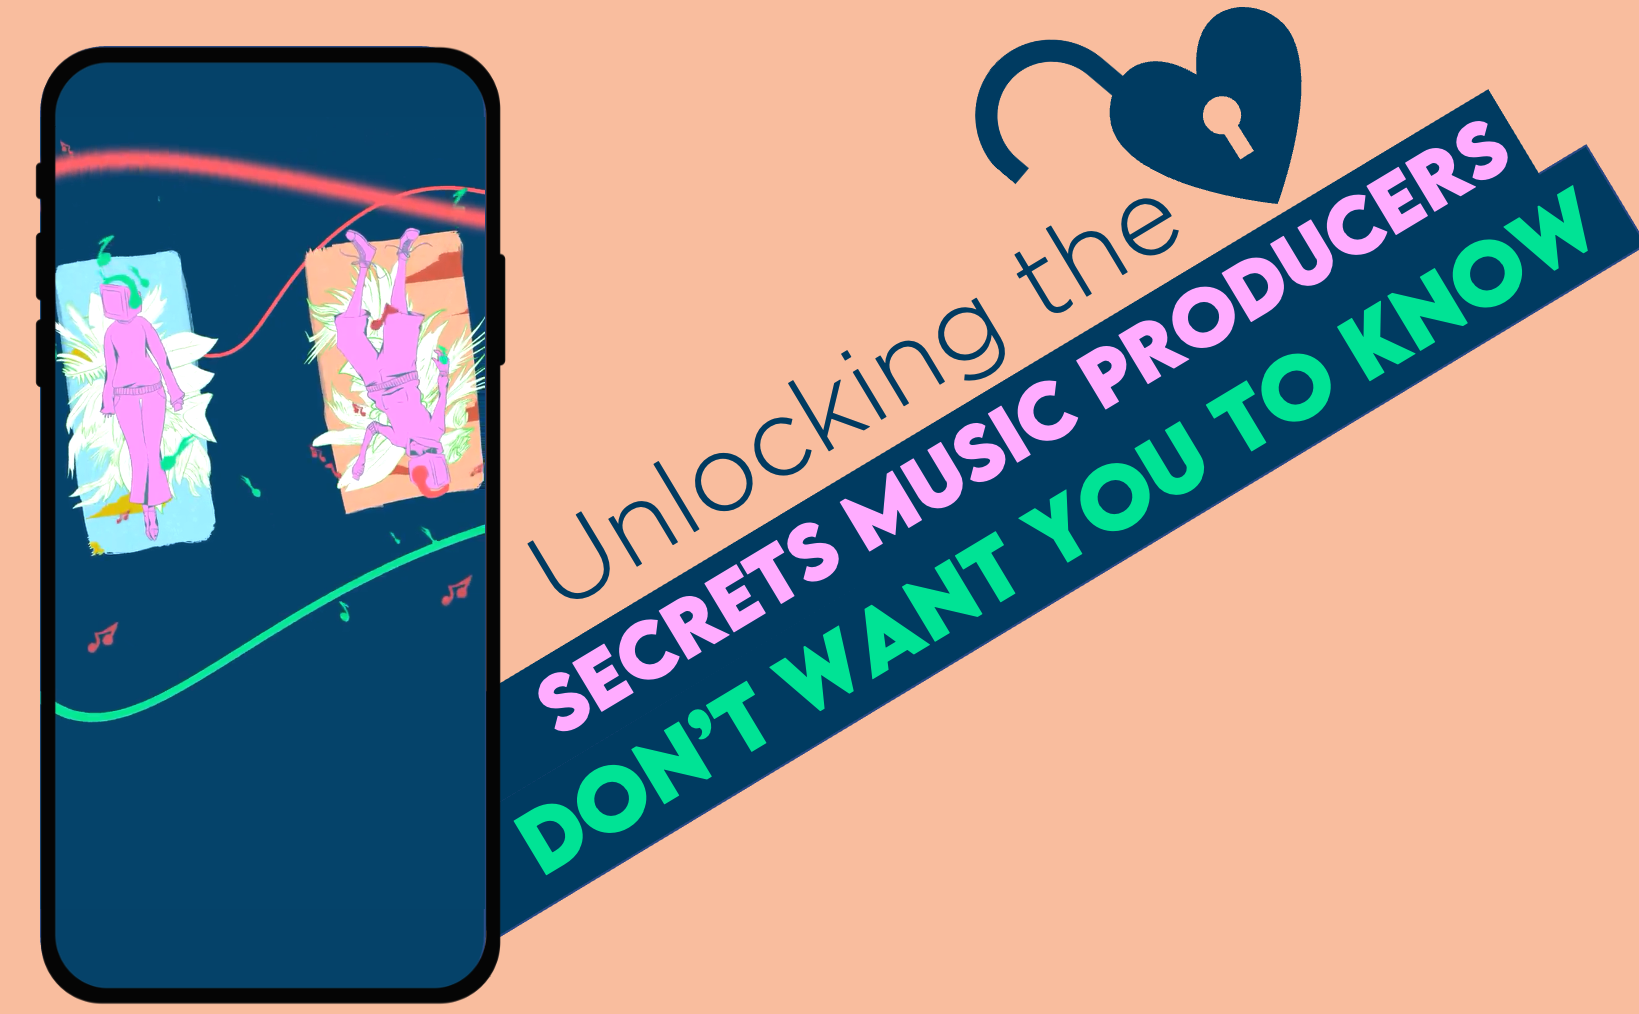

<a id='ExecSum'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">EXECUTIVE SUMMARY</h1>

Although an artist's reputation and popularity can influence the success of a song, there are other factors that may contribute to its hit potential. This study aimed to create a machine learning model that predicts hit songs based on their features. Using Spotify API, the team collected data on songs from 2010-2019 and trained a machine learning model that achieved an $82.28\%$ accuracy rate. Using `shap`, the top three most influential features to the model's predictions were identified to be `instrumentalness`, `energy`, `danceability`. The team also used `dice_ml` to generate counterfactuals for flop songs to determine how to turn such songs into hits with only minimal changes to the song's features.

It is important to note that the dataset has its limitations, including the team's focus only on the 2010-2019 data. Training the same model on a different set of songs will result to different insights as music trends tend to change over time. This model can be used by artists, record labels, streaming platforms, and advertisers, to make informed decisions on their businesses. Potential future work include exploring more refined definitions of the prediction target and incorporating artist popularity as a feature for model prediction.

Overall, the study provides valuable insights into the features that contribute to a song's success and offers a practical tool for decision-making in the music industry.

<a id='TContents'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">TABLE OF CONTENTS</h1>

[EXECUTIVE SUMMARY](#ExecSum) <br> 
[IMPORT LIBRARIES AND DEFINE FUNCTIONS](#Libraries) <br> 
[LIST OF TABLES AND FIGURES](#Tables) <br> 

[I. PROBLEM STATEMENT](#Problem) <br> 
[II. MOTIVATION](#Motiv) <br> 
[III. METHODOLOGY](#Methodology) <br> 
[IV. DATA COLLECTION](#Collection) <br> 
- [Data Source](#Source) <br>
- [Data Description](#Description) <br>
- [Data Collection and Database Creation](#CC) <br>

[V. DATA PREPROCESSING AND EXPLORATION](#Exploration) <br> 
[VI. MODEL SELECTION](#Model) <br>
[VII. RESULTS AND DISCUSSION](#Results) <br>
- [SHAP](#SHAP) <br>
- [DiCE](#DiCE) <br>
- [Demo_01: Hit](#Demo_01) <br>
- [Demo_02: Flop](#Demo_02) <br>
- [Demo_03: Flop](#Demo_03) <br>

[VIII. CONCLUSION](#Conclusion) <br> 
[IX. RECOMMENDATION](#Recommendation1) <br> 
- [Limitations of the Study](#Limitations)
- [Recommendation](#Recommendation2) <br>
- [Future Work](#FutureWork) <br> 

[REFERENCES](#References) <br> 

<a id='Libraries'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">IMPORT LIBRARIES</h1>

This section involves importing the necessary libraries and defining the required functions, including global libraries and helper functions, and procedural functions for data preparation. This step lays the foundation for the subsequent analysis and modeling steps.

<h2 style="color:#3C89F3">A. Global Libraries & Functions</h2> 

This step involves importing global libraries and defining global helper functions that will be used throughout the notebook.

<h3 style="color:#222f3e">A1. Global Libraries</h3>

The team imported several python libraries and modules which are important for tasks such as data cleaning, visualization, error handling, machine learning and AI explainability. This is where the team set the global pandas settings and color variables to control how the output will be displayed. This helps the team ensure consistency in the report.

In [4]:
# Libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import joblib

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     GridSearchCV)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, recall_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN

# Interpretability techniques
import shap
from dice_ml import Model, Dice, Data

# Scraping
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Other important supporting libraries and modules
from PIL import Image
import pickle
from urllib.parse import urljoin
from tqdm.notebook import tqdm, trange
import warnings
from sklearn.exceptions import ConvergenceWarning
from IPython.display import display, display_html

# Global settings
%matplotlib inline

# Pandas and Seaborn settings
# pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)
sns.set_theme('notebook', 'white', 'colorblind')
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
rng = np.random.RandomState(20)

# Error Filters
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Global variables
c_peach = "#fcc5a8"
c_lightpink = "#f8d2d1"
c_green = "#00e79f"
c_pink = "#ffb5ff"
c_darkblue = "#00436c"
c_shap_pink = "#EA3355"
c_shap_blue = "#3C89F3"

<h3 style="color:#222f3e"> A2. Global Helper Functions</h3>

The following global helper functions are prepared and summarized in this single location to keep it organized, ensure consistency, and make code more readable and easier to maintain.

In [5]:
def preview_df(df, display_df=True):
    """Displays the number of data points, nulls, statistics, and preview
    of the dataframe."""
    display_html(f'<b>Number of Data Points:</b> {df.shape[0]}',
                 raw=True)
    display_html(f'<b>Number of Features:</b> {df.shape[1]}',
                 raw=True)
    display_html(f'<b>Number of Nulls:</b> {df.isna().any(axis=1).sum()}',
                 raw=True)
    if display_df:
        # Display first 3 rows of the df
        print(f'First three rows of the df:\n')
        display(df.head(3))
        # Get summary statistics for the numerical columns and transpose the
        # DataFrame for more readable output
        print(f'\nSummary statistics for numerical columns:\n')
        display(df.describe())
    else:
        print('Count of missing values:')
        display(df.isna().sum())


def get_data(agg=False):
    """Get the aggregated data of songs from 1960 to 2019."""
    dup_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'duration_ms', 'time_signature',
                'chorus_hit', 'sections']
    df_dict = {}
    for path in os.listdir('data/')[:]:
        df = pd.read_csv(os.path.join('data/', path))
        decade = re.search('-(\d\d)s', path).group(1)
        if int(decade[0]) <= 2:
            df['decade'] = int(f'20{decade}')
        else:
            df['decade'] = int(f'19{decade}')
        df_dict.update({
            df['decade'].iloc[0]:
            df.drop('decade', axis=1).drop_duplicates(subset=dup_cols)
        })
    if agg:
        df = pd.concat(df_dict.values())
        return df.drop_duplicates(subset=dup_cols).reset_index(drop=True)
    else:
        return df_dict


def plot_hist_all(df):
    """Plot the distribution of the features and target variable."""
    feats = ['danceability', 'energy', 'key', 'loudness', 'mode',
             'speechiness', 'acousticness', 'instrumentalness', 'liveness',
             'valence', 'tempo', 'duration_ms', 'time_signature',
             'chorus_hit', 'sections']
    fig, ax = plt.subplots(4, 4, figsize=(6.4*4, 4.8*4))
    ax = ax.flatten()
    fig.delaxes(ax[-1])
    for i, (feat, vals) in enumerate(df[feats].T.iterrows()):
        sns.histplot(x=vals, hue=df.target, multiple='stack', ax=ax[i])
    fig.canvas.draw()
    fig.savefig('Images/grid.png', transparent=True)


def plot_target_dist(df):
    """Plot the distribution of the target variable."""
    counts = df.target.value_counts()
    fig = plt.figure()
    counts.plot.bar(color=sns.color_palette('colorblind'))
    plt.xticks(rotation=0)
    fig.savefig('Images/target_dist.png', transparent=True)


def plot_corr(df, feats):
    """Plot a heatmap of the correlation of features in the dataset."""
    plt.figure(figsize=(15, 12))
    sns.heatmap(df[feats].corr(), annot=True)
    plt.xticks(rotation=50, ha='right')


def get_feats_and_target(df, split_dict=None):
    """Construct machine learning features and target variables."""
    X = df[feats]
    y = df.target
    if split_dict is None:
        return X, y
    else:
        return train_test_split(X, y, stratify=y, **split_dict)


def log_transform(x):
    """Log-transform the passed feature values."""
    return np.log(x + 1)


def run_ml(X_trainval, y_trainval, gs_params):
    """Run a grid search to obtain the best model."""
    try:
        gs = joblib.load('gs.pkl')
    except:
        gs = GridSearchCV(**gs_params)
        gs.fit(X_trainval, y_trainval)
        joblib.dump(gs, 'gs.pkl')
    return gs


def get_scores(gs, X_test, y_test):
    """Get the model's scores."""
    best_idx = gs.cv_results_['mean_test_score'].argmax()
    print(f"Train Accuracy: "
          f"{gs.cv_results_['mean_train_score'][best_idx]*100:.2f}%")
    print(f'Validation Accuracy: {gs.best_score_*100:.2f}%')
    print(f'Test Accuracy: {gs.score(X_test, y_test)*100:.2f}%')


def predict_new_song(model, new_song_df, chorus_hit, prompt=False):
    """
    Predict whether a song which is not in the database is a hit or a flop.
    The chorus hit feature must be manually imputed.
    """
    cols = ['danceability', 'energy', 'speechiness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit']
    df = new_song_df.copy()
    df['chorus_hit'] = chorus_hit
    if prompt:
        display(df[cols])
    return df[cols], gs.predict(df[cols])


def scrape_track(song_title, artist):
    """Returns the dataframe containing spotify data and the hit (1) or 
    flop (0) prediction.
    """
    # Set up Spotipy with your credentials
    client_id = 'ee9df8961aa840f2b6c237aa99eed03a'
    client_secret = 'b59023df0ccc41c287a0b6f8bcbb4e4e'
    client_credentials_manager = SpotifyClientCredentials(
        client_id=client_id, client_secret=client_secret
    )
    sp = spotipy.Spotify(
        client_credentials_manager=client_credentials_manager
    )

    # Define a list of track and artist names
    tracks = [(song_title, artist)]

    # Create empty lists to store the audio features, release dates, track
    # names, and artist names
    audio_features_list = []
    release_dates_list = []
    track_names_list = []
    artist_names_list = []

    # Loop through each track and artist name in the list
    for track_name, artist_name in tracks:

        # Search for the track using the track and artist name
        results = sp.search(
            q=f'track:{track_name} artist:{artist_name}', type='track'
        )

        # Get the first track in the search results
        track = results['tracks']['items'][0]

        # Get the audio features for the track
        audio_features = sp.audio_features([track['id']])[0]

        # Get the release date for the track
        album = sp.album(track['album']['id'])
        release_date = album['release_date']

        # Add the audio features, release date, track name, and artist name to
        # the respective lists
        audio_features_list.append(audio_features)
        release_dates_list.append(release_date)
        track_names_list.append(track_name)
        artist_names_list.append(artist_name)

    # Convert the audio features, release dates, track names, and artist names
    # to pandas dataframes
    audio_features_df = pd.DataFrame(audio_features_list)
    release_dates_df = pd.DataFrame({'release_date': release_dates_list})
    track_names_df = pd.DataFrame({'track_name': track_names_list})
    artist_names_df = pd.DataFrame({'artist_name': artist_names_list})

    # Concatenate the dataframes
    df = pd.concat([track_names_df, artist_names_df,
                   audio_features_df, release_dates_df], axis=1)

    # Print the pandas dataframe
    return df


def demo_result(song_title, artist, chorus_hit, song_db, n=10):
    """Returns the dataframe, prediction, and prediction probability.
    """
    Demo = scrape_track(song_title, artist)
    query, pred = predict_new_song(gs, Demo, chorus_hit, prompt=True)

    # Get cf_list
    features_to_vary = ['danceability', 'valence', 'instrumentalness',
                        'tempo']

    cfes = dice_exp.generate_counterfactuals(
        query,
        total_CFs=50,
        desired_class='opposite',
        features_to_vary=features_to_vary
    )
#     cfes.visualize_as_dataframe(show_only_changes=True)

    local_feat_importance = dice_exp.local_feature_importance(
        query, total_CFs=100, features_to_vary=features_to_vary)

    cf_list = cfes.cf_examples_list[0].final_cfs_df.drop('target', axis=1)

    print(f'Prediction: {pred}\n'
          f'Prediction Probabilities:')
    display(gs.predict_proba(query))
    if pred[0] == 0:
        print('Closest hit songs:\n')
        display(closest_hit_songs(song_db, cf_list, query, N=n))

    client_shap_values = shap_explainer(query)
    client_shap_explanation = shap.Explanation(
        client_shap_values.values[:, :, 1],
        client_shap_values.base_values[0][1],
        client_shap_values.data, feature_names=X_trainval.columns
    )
    shap.plots.waterfall(client_shap_explanation[0], max_display=5)


def build_pct_change_df(client, cf_list):
    """
    Build the percent change dataframe for the counterfactuals.
    """
    rows = []
    for i, row in cf_list.iterrows():
        rows.append(
            ((row - client.squeeze()) / client.squeeze()).abs()
        )
    return pd.concat(rows, axis=1).T


def get_nearest_titles(samples, query, N=10, return_titles=False):
    """
    Return the titles of the nearest neighbors to the counterfactual query.
    """
    knn = NearestNeighbors(n_neighbors=N, algorithm='auto')
    knn.fit(samples[query.columns].to_numpy())
    indices = knn.kneighbors(query.to_numpy(),
                             return_distance=False).flatten()
    if return_titles:
        return (
            samples.iloc[indices]
            #             [['track', 'artist']]
            #             .to_numpy()
            #             .tolist()
        )
    return indices


def closest_hit_songs(song_db, cf_list, query, cf_query=None, N=10):
    """
    Get the titles of the closest hit songs to the given query.
    """
    if cf_query is not None:
        return get_nearest_titles(song_db[song_db.target == 1], cf_query, N=N,
                                  return_titles=True)
    cf_query = cf_list.iloc[get_nearest_titles(cf_list, query, N=1)]
    return get_nearest_titles(song_db[song_db.target == 1], cf_query, N=N,
                              return_titles=True)

[Back to TOC](#TContents)

<a id='Tables'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">LIST OF TABLES AND FIGURES</h1>

**TABLES**

- Table 1. Methodology Details
- Table 2. Data Description and Details
- Table 3. Demo_02: DiCE Counterfactuals to turn 'Space Song' to a hit.

**FIGURES**

- Figure 1. Methodology
- Figure 2. Histogram Plots of Track Features
- Figure 3. Distribution of Target Variable	
- Figure 4. Correlation Plot of Track Features
- Figure 5. Correlation Plot of Track Features (Post-cleansing)
- Figure 6. SHAP Summary Bar Plot for Global Explanation
- Figure 7. SHAP Beeswarm Plot for Global Explanation
- Figure 8. DiCE Feature Importance Plot for Global Explanation
- Figure 9. Demo_01: SHAP Waterfall Plot for Local Explanation
- Figure 10. Demo_02: SHAP Waterfall Plot for Local Explanation
- Figure 11. Demo_02: DiCE Feature Importance Plot for Local Explanation
- Figure 12. Demo_03: SHAP Waterfall Plot for Local Explanation (Flop Version)
- Figure 13. Demo_03: SHAP Waterfall Plot for Local Explanation (Hit Version)

[Back to TOC](#TContents)

<a id='Problem'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">I. PROBLEM STATEMENT</h1>

In the music industry, one source of income for artists come from the number of streams they get on a music platform. However, due to millions of songs being released daily, only a few get to be on top. 

While an artist's popularity and reputation can play a significant role in the success of a song, there are other factors that contribute to a song becoming a hit. 

To uncover the secret formula of a hit song, the team will explore predicting a song's success based on various features available from Spotify dataset, and attempt to identify the elements that artists can focus on tweaking to maximize their chances of creating a hit song. As such, the team will focus on creating a solution to the following problem statement:

***How to turn songs from FLOP to HIT?***

<a id='Motiv'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">II. MOTIVATION</h1>

Understanding the key factors that drive a song's success is crucial for artists, record labels, songwriters, producers, and other stakeholders in the rapidly changing music industry. Discovering the secret formula for a hit song empowers artists to optimize their creative process and enables industry stakeholders to make informed and data-driven decisions regarding marketing and talent discovery and development. 

Insights into the qualitative features that contribute to a song's popularity could prove invaluable in shaping the future of the music industry as streaming and social media platforms continue to dominate music consumption. 

This report aims to bridge the gap between artistic vision and commercial success, benefiting the entire music ecosystem and fostering the creation of exceptional music that resonates with global audiences while considering vital song characteristics and contents.

[Back to TOC](#TContents)

<a id='Methodology'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">III. METHODOLOGY</h1>

As illustrated in ***Figure 1: Methodology***, the methodology section of this report consists of a four-step process, beginning with the collection of publicly available Spotify dataset, followed by data preprocessing and exploration, model selection, and results and discussion. The results and discussion section presents demonstrations of the model and the applications of the interpretability techniques such as **SHAP** (or Shapley Additive Values) and **DiCE** (or Diverse Counterfactual Explanations) to get actionable insights based on global and local explanations obtained from the model.

Refer to ***Table 1: Methodology Details*** for more details about each step.

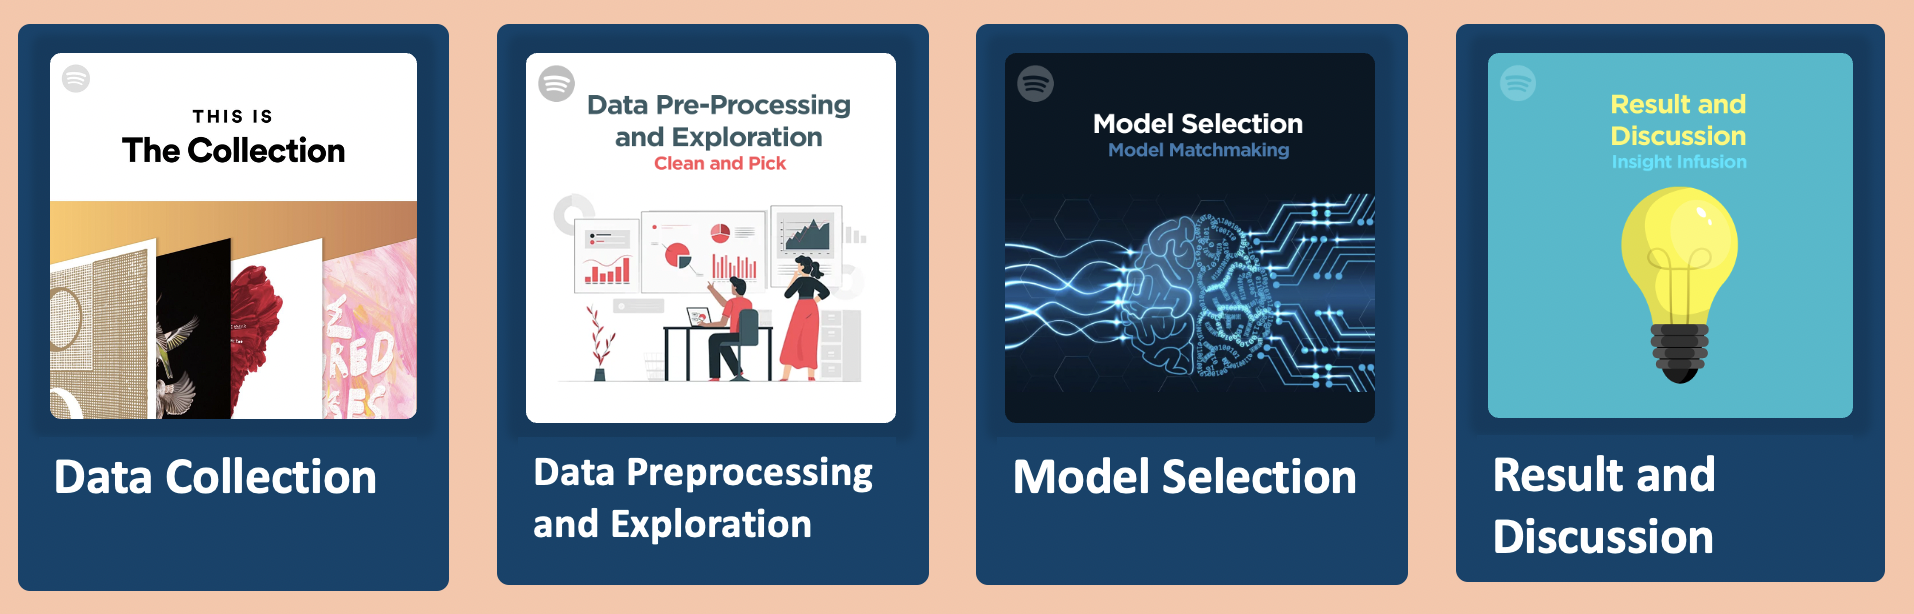

<center><span style="font-size:14px"><b>Figure 1. </b>Methodology</span></center>

<table >
    <tr style="color:#00436c; background-color:#fcc5a8; font-size:14px">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Step</th>
        <th style="text-align: left">Description</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">Data Collection</td>
        <td style="text-align: left">Collect publicly available Spotify Dataset focusing on specific song features such as Danceability, Valence, and the like.</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">Data Preprocessing and Exploration</td>
        <td style="text-align: left">Prepare and clean the collected dataset to ensure its quality and suitability for further analysis. Perform EDA to explore and understand the relationships between the features, identify any trends/patterns, and provide insights regarding the Spotify dataset.</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">Model Selection</td>
        <td style="text-align: left">Split data, perform transformations, tune hyperparameters, then select and evaluate the model to be used to predict if a song will be a hit or a flop.</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">Result and Discussion</td>
        <td style="text-align: left">Based on the created Machine Learning (ML) Model, provide three demonstrations of the model by interpreting the prediction outputs of the model for specific scenarios.</td>
    </tr>
</table>

<center><span style="font-size:14px"><b>Table 1. </b>Methodology Details</span></center>

[Back to TOC](#TContents)

<a id='Collection'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">IV. DATA COLLECTION</h1>

The data collection section involves three key steps:

1. Identifying the data source;
1. Describing the data; and
1. Collecting the data.

<a id='Source'></a>
<h2 style="color:#3C89F3">A. Data Source</h2> 

The team initially obtained the aggregated songs data from 1960 to 2019 or the Spotify Hit Predictor Dataset that the Kaggle author, Farooq Ansari, scraped using Spotify's Web API. [[1]](#dataset). 

The Spotify dataset is in the form of a Comma-Separated Values (csv) files that were downloaded from the link: `https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset?select=dataset-of-10s.csv`. Then loaded in this notebook using Pandas.

After exploring the different decades of the Spotify dataset, the team carefully selected only the **2010-2019** decade as the dataset for predicting hit or flop songs due to its relevance in today's music industry. Trends and tastes in music can evolve rapidly, and this decade provides the most current data to analyze. Furthermore, the music industry has undergone significant changes in recent years due to technological advancements and shifts in consumer behavior. By focusing on this specific time period, the team can better account for these changes and identify non-obvious qualities that may contribute to a song's success. The dataset includes a diverse range of 6252 unique songs and 2662 unique artists, providing a reasonable sample size for analysis.

<a id='Description'></a>
<h2 style="color:#3C89F3">B. Data Description</h2> 

The following features were used and considered relevant for this report:

<table >
    <tr style="color:#00436c; background-color:#fcc5a8; font-size:14px">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Feature Name</th>
        <th style="text-align: left">Feature Description</th>
        <th style="text-align: left">Data Type</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">danceability</td>
        <td style="text-align: left">Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">energy</td>
        <td style="text-align: left">Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">key</td>
        <td style="text-align: left">The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C#/Db, 2 = D, and so on. If no key was detected, the value is -1.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">loudness</td>
        <td style="text-align: left">The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">5.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">mode</td>
        <td style="text-align: left">Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.</td>
        <td style="text-align: left">Binary</td>
    </tr>
    <tr>
        <td style="text-align: left">6.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">speechiness</td>
        <td style="text-align: left">Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">7.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">acousticness</td>
        <td style="text-align: left">A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">8.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">instrumentalness</td>
        <td style="text-align: left">Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">9.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">liveness</td>
        <td style="text-align: left">Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">10.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">valence</td>
        <td style="text-align: left">A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">11.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">tempo</td>
        <td style="text-align: left">The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">12.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">duration_ms</td>
        <td style="text-align: left">The duration of the track in milliseconds.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">13.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">time_signature</td>
        <td style="text-align: left">An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">14.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">chorus_hit</td>
        <td style="text-align: left">This the source's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">15.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">sections</td>
        <td style="text-align: left">The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.</td>
        <td style="text-align: left">Numeric</td>
    </tr>
    <tr>
        <td style="text-align: left">16.</td>
        <td style="text-align: left; font-weight: bold; color:#00436c;">target</td>
        <td style="text-align: left">The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.<br>
        The condition of a track being 'flop' is as follows:
        <ul>
            <li>The track must not appear in the 'hit' list of that decade. </li>
            <li>The track's artist must not appear in the 'hit' list of that decade. </li>
            <li>The track must belong to a genre that could be considered non-mainstream and / or avant-garde. </li>
            <li>The track's genre must not have a song in the 'hit' list. </li>
            <li>The track must have 'US' as one of its markets. </li>
            </ul>
        </td>
        <td style="text-align: left">Binary</td>
    </tr>
</table>

<center><span style="font-size:14px"><b>Table 2. </b>Data Description and Details</span></center>

<a id='CC'></a>
<h2 style="color:#3C89F3">C. Data Collection</h2> 

To start processing the dataset, the team executed the following codes:

```python
# Returns the 2010-2019 Spotify data and saves it to a DataFrame, `df_db`.
df_db = get_data()[2010]
```

In [6]:
df_db = get_data()[2010]

[Back to TOC](#TContents)

<a id='Exploration'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">V. DATA PREPROCESSING AND EXPLORATION</h1>

In this section, the team discussed the critical steps taken to preprocess and explore the collected Spotify dataset. Data preprocessing is an essential stage in any data analysis project, and it involves preparing and cleaning the dataset to ensure its quality and suitability for further analysis. This includes handling missing values, dealing with duplicates, and ensuring data consistency.

Once the dataset is ready for analysis, the team conducted an exploratory data analysis (EDA) to gain a better understanding of the relationships between the features. EDA allows us to identify any trends or patterns within the data, provide insights regarding the dataset's characteristics, and inform the feature selection process for predictive modeling. The team's aim is to extract meaningful insights from the data to support the goal of predicting the success of songs on Spotify.

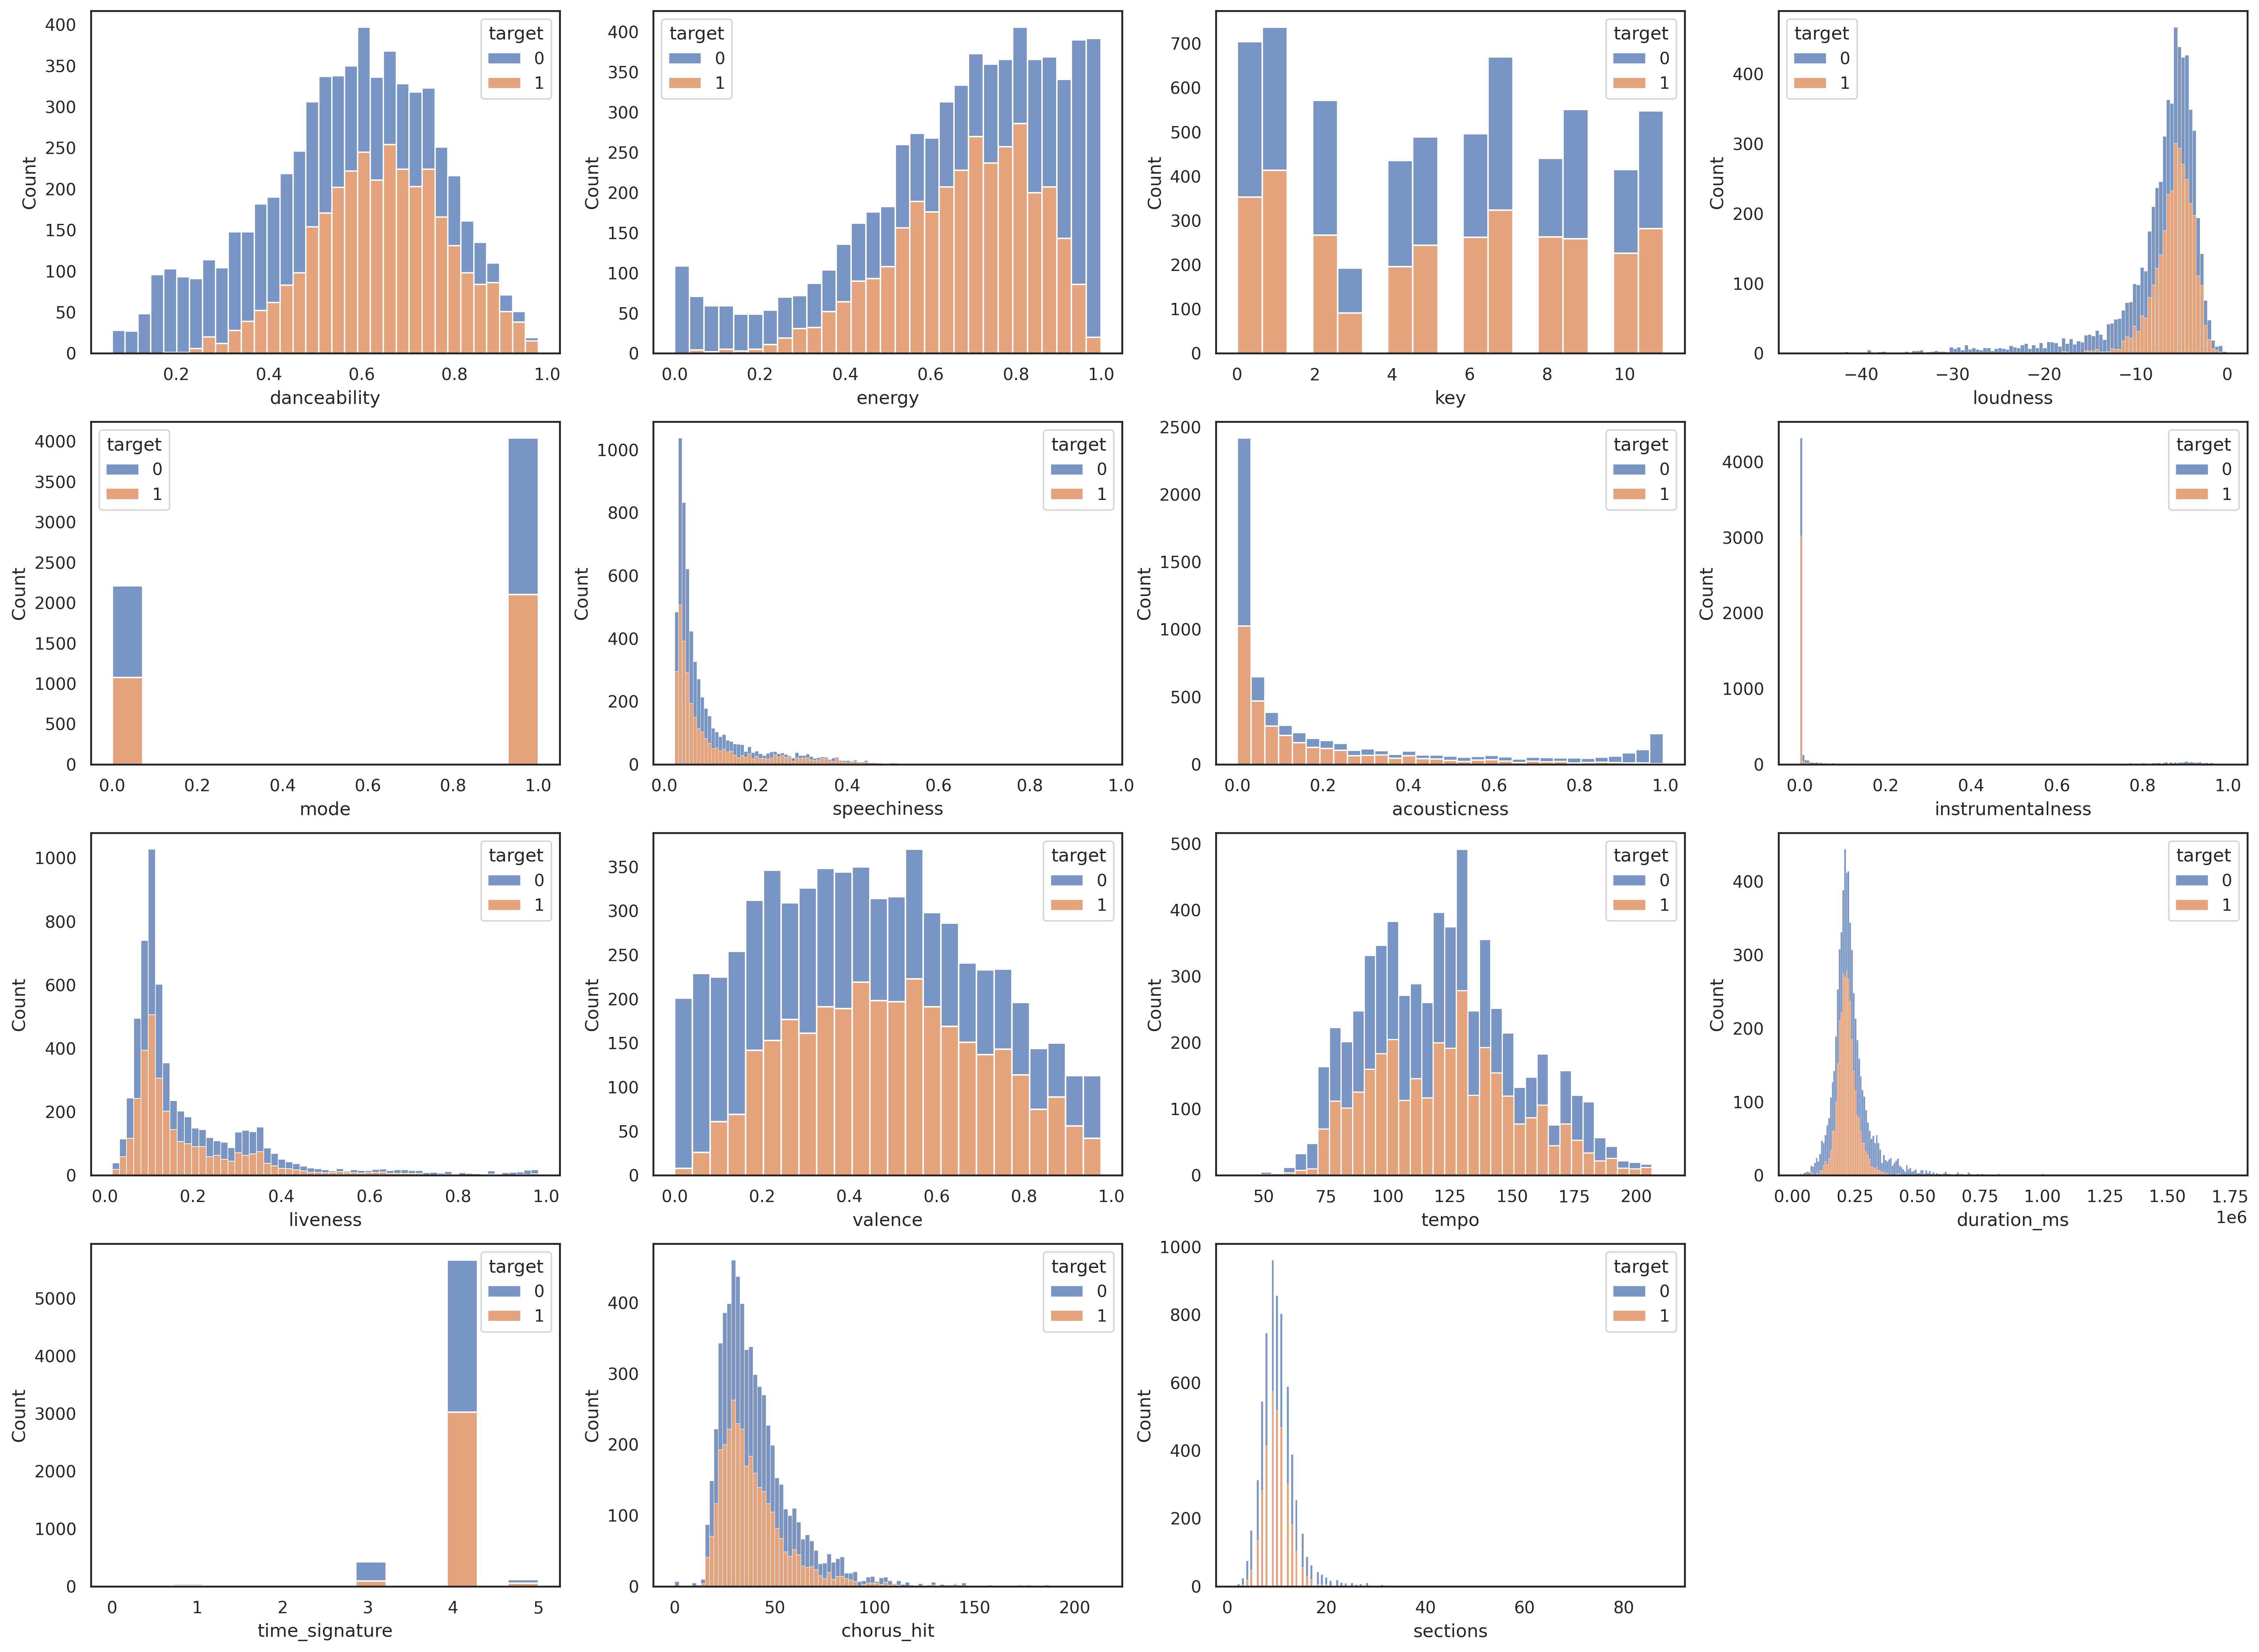

In [7]:
with sns.axes_style('white'):
    plot_hist_all(df_db)

<center><span style="font-size:14px"><b>Figure 2. </b>Histogram Plots of Track Features</span></center>

**Insight:** Some features are highly skewed. To mitigate this, the features `speechiness`, `instrumentalness`, and `liveness` are to be Log-transformed.

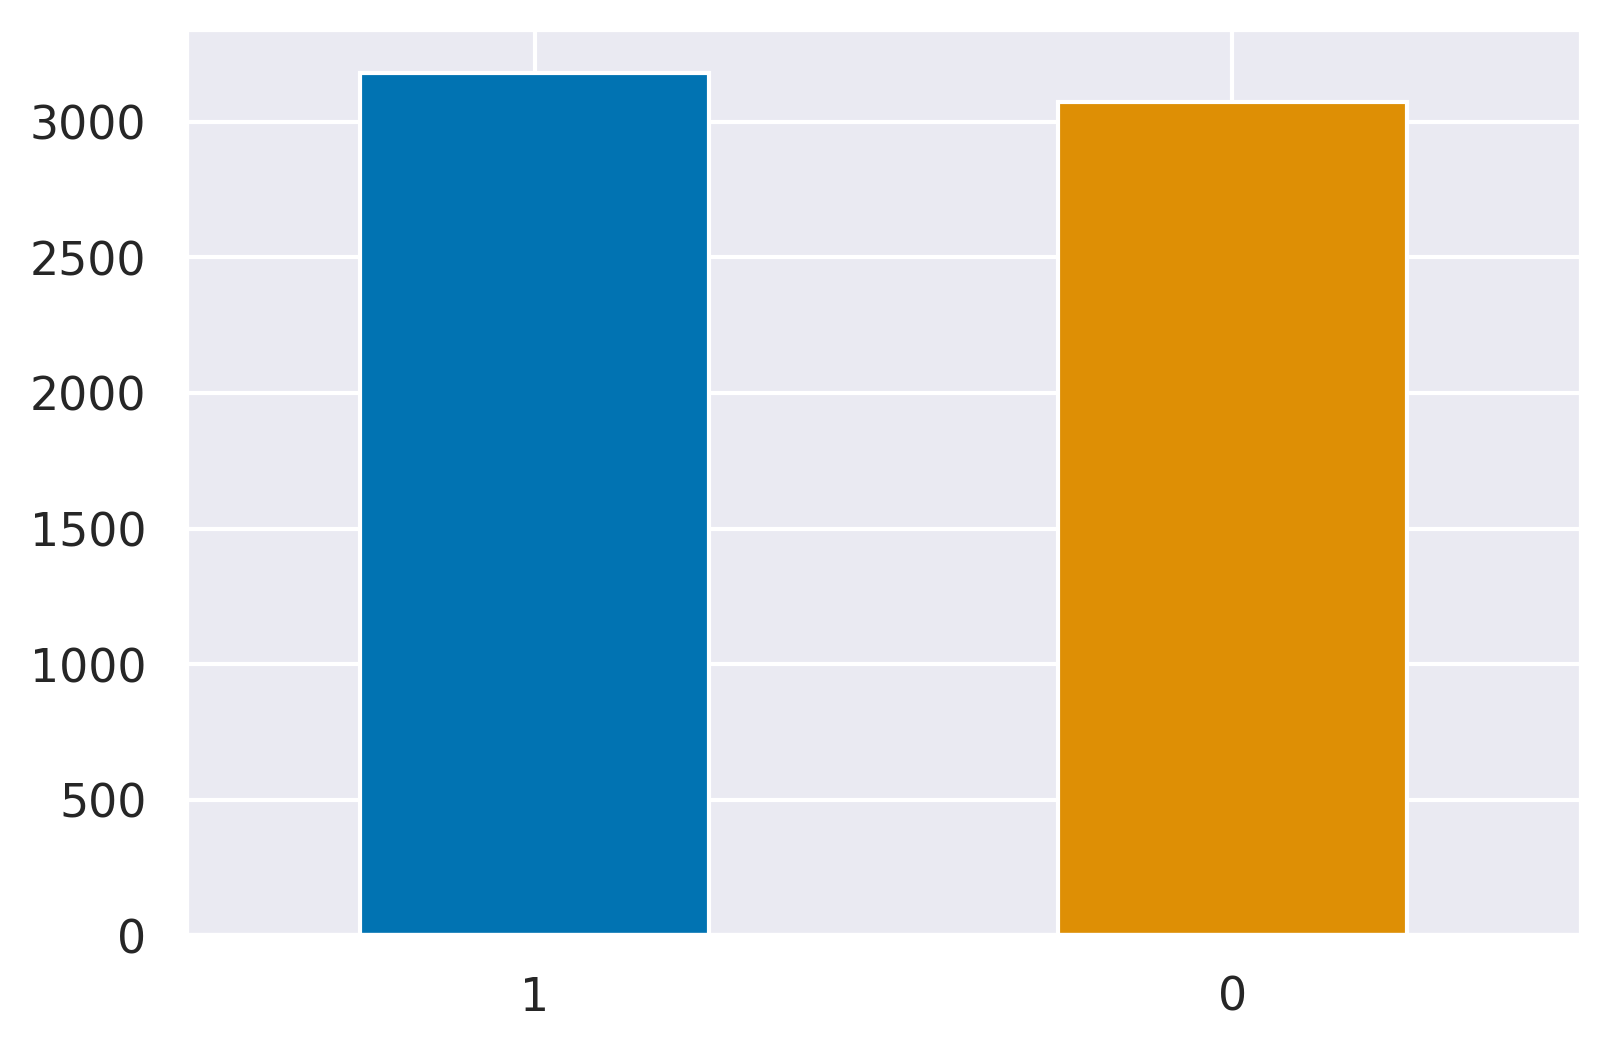

In [8]:
plot_target_dist(df_db)

<center><span style="font-size:14px"><b>Figure 3. </b>Distribution of Target Variable</span></center>

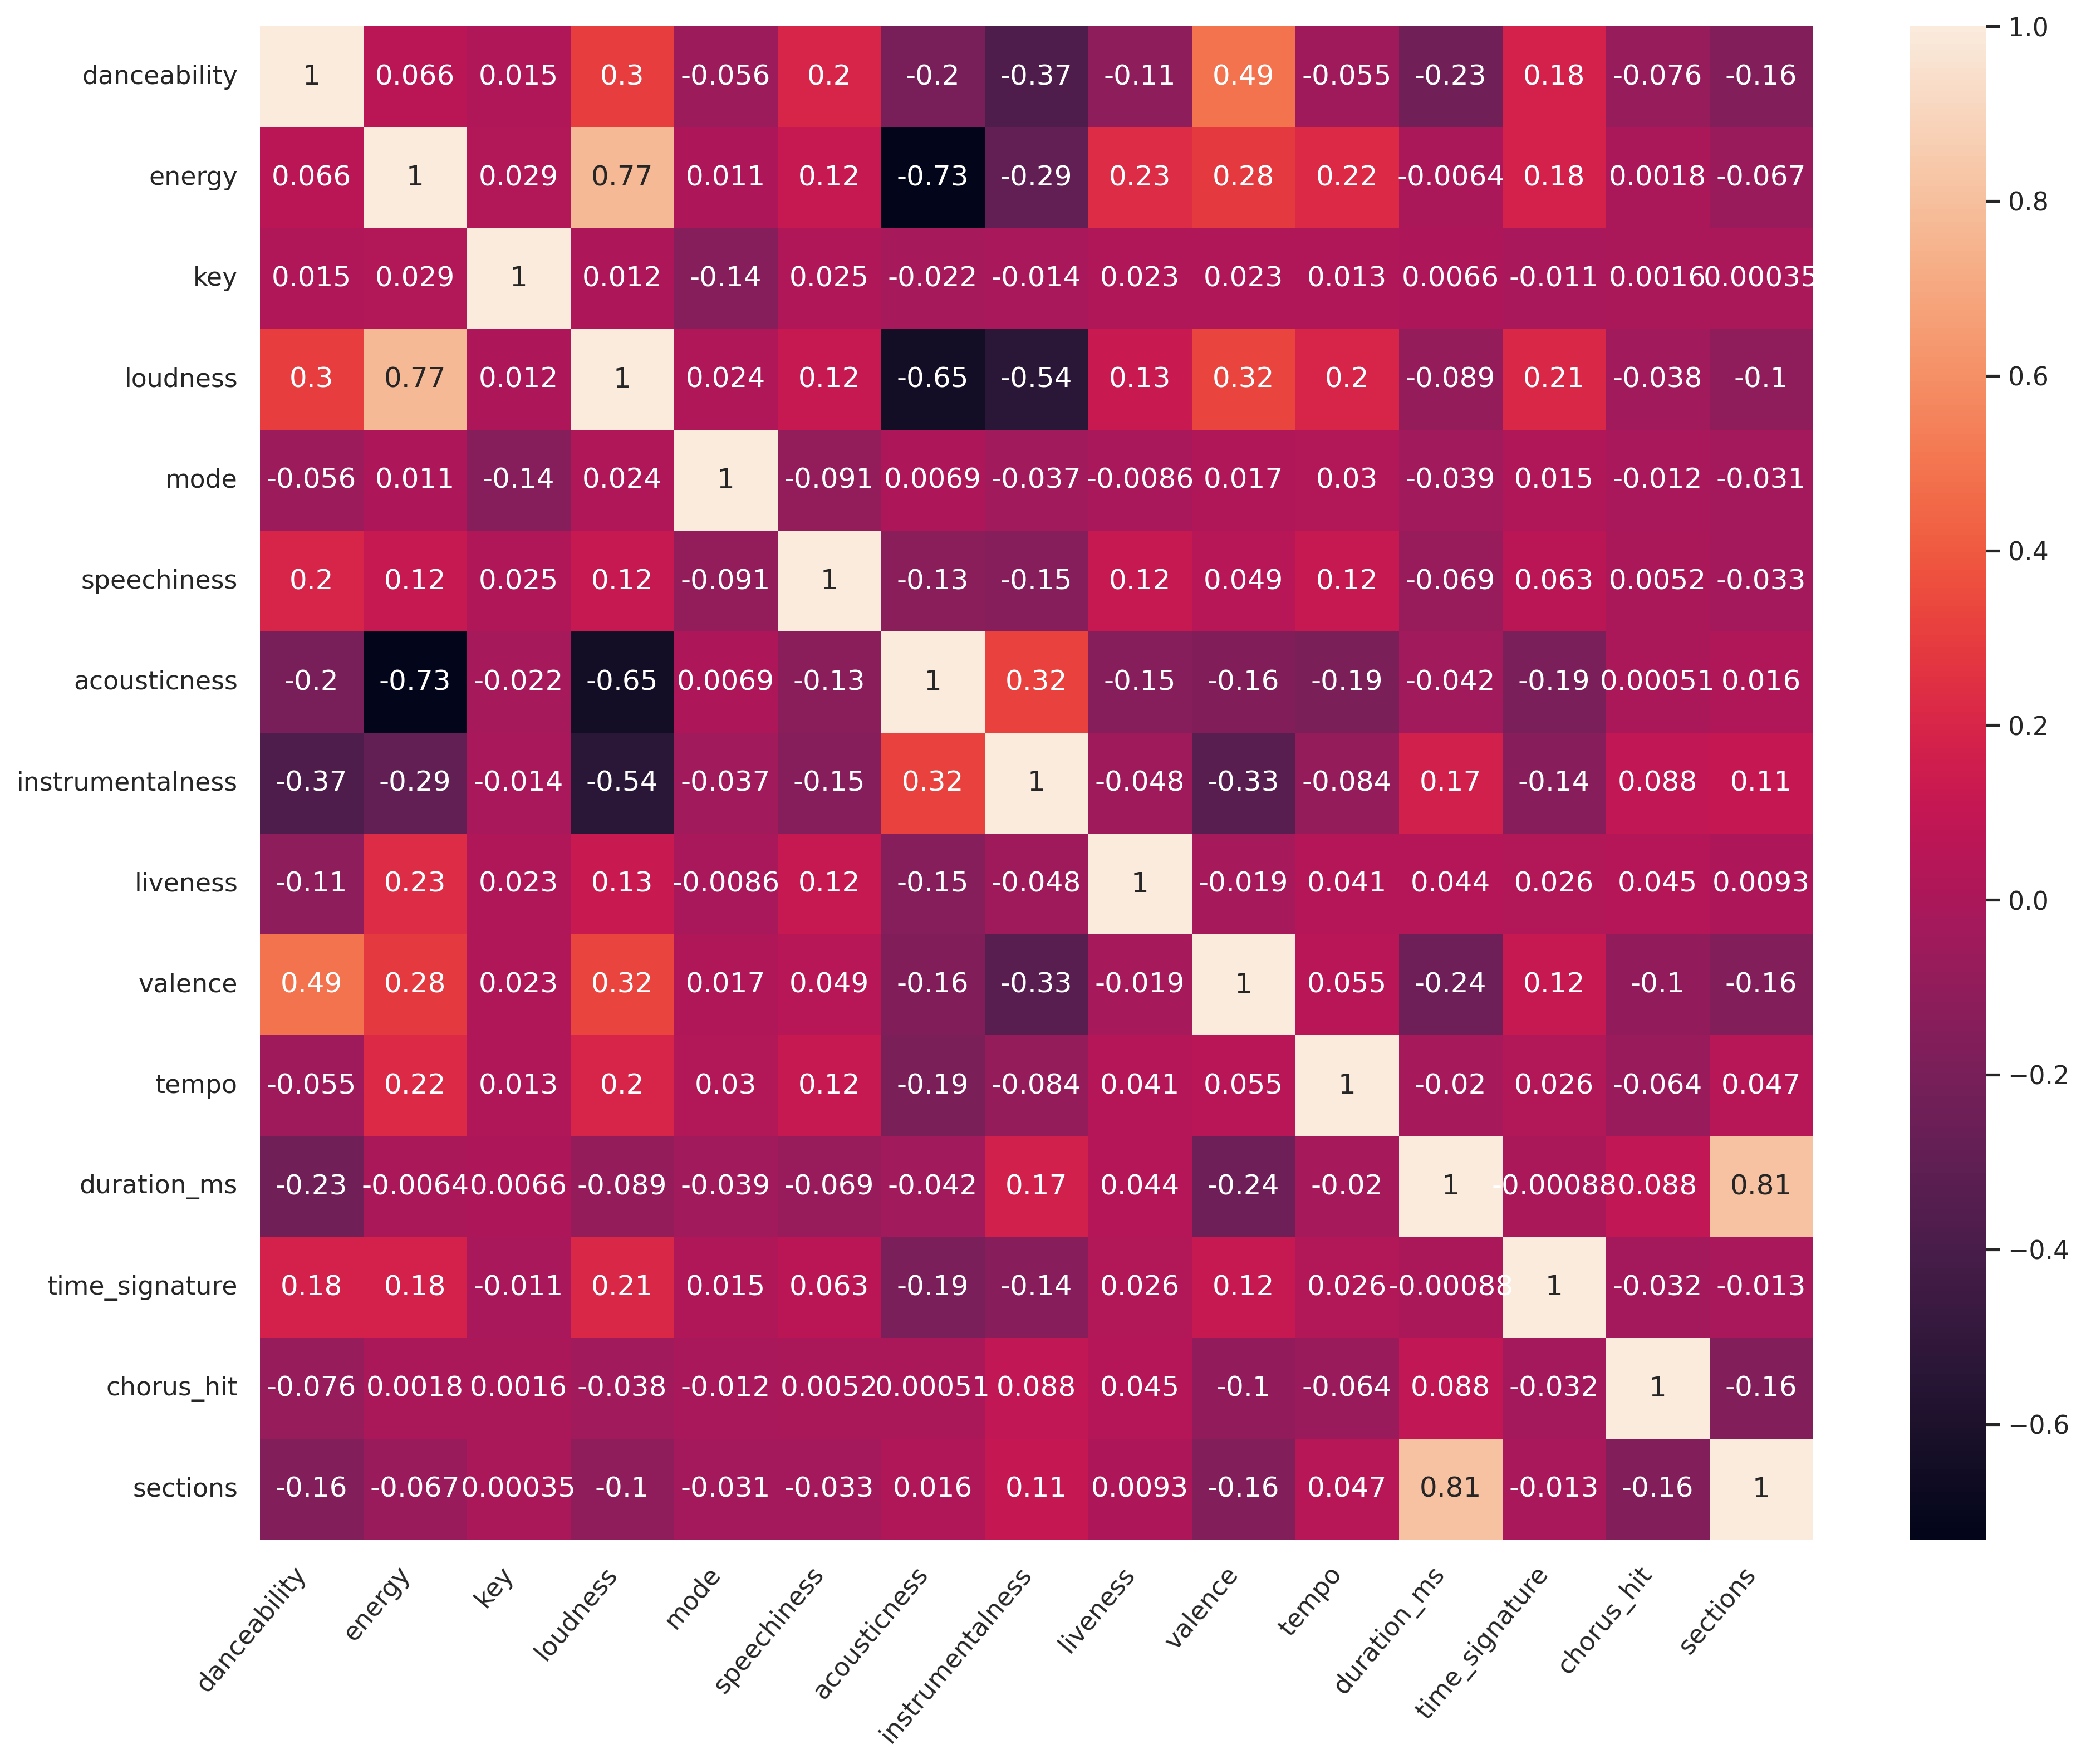

In [9]:
feats = ['danceability', 'energy', 'key', 'loudness', 'mode',
         'speechiness', 'acousticness', 'instrumentalness', 'liveness',
         'valence', 'tempo', 'duration_ms', 'time_signature',
         'chorus_hit', 'sections']

plot_corr(df_db, feats)

<center><span style="font-size:14px"><b>Figure 4. </b>Correlation Plot of Track Features</span></center>

**Insight**: Drop `loudness`, `acousticness` and `sections` due to high correlations with other features. In particular,
- `loudness` positively correlates with `energy`
- `acousticness` negatively correlates with `energy`
- `sections` positively correlates with `duration_ms`

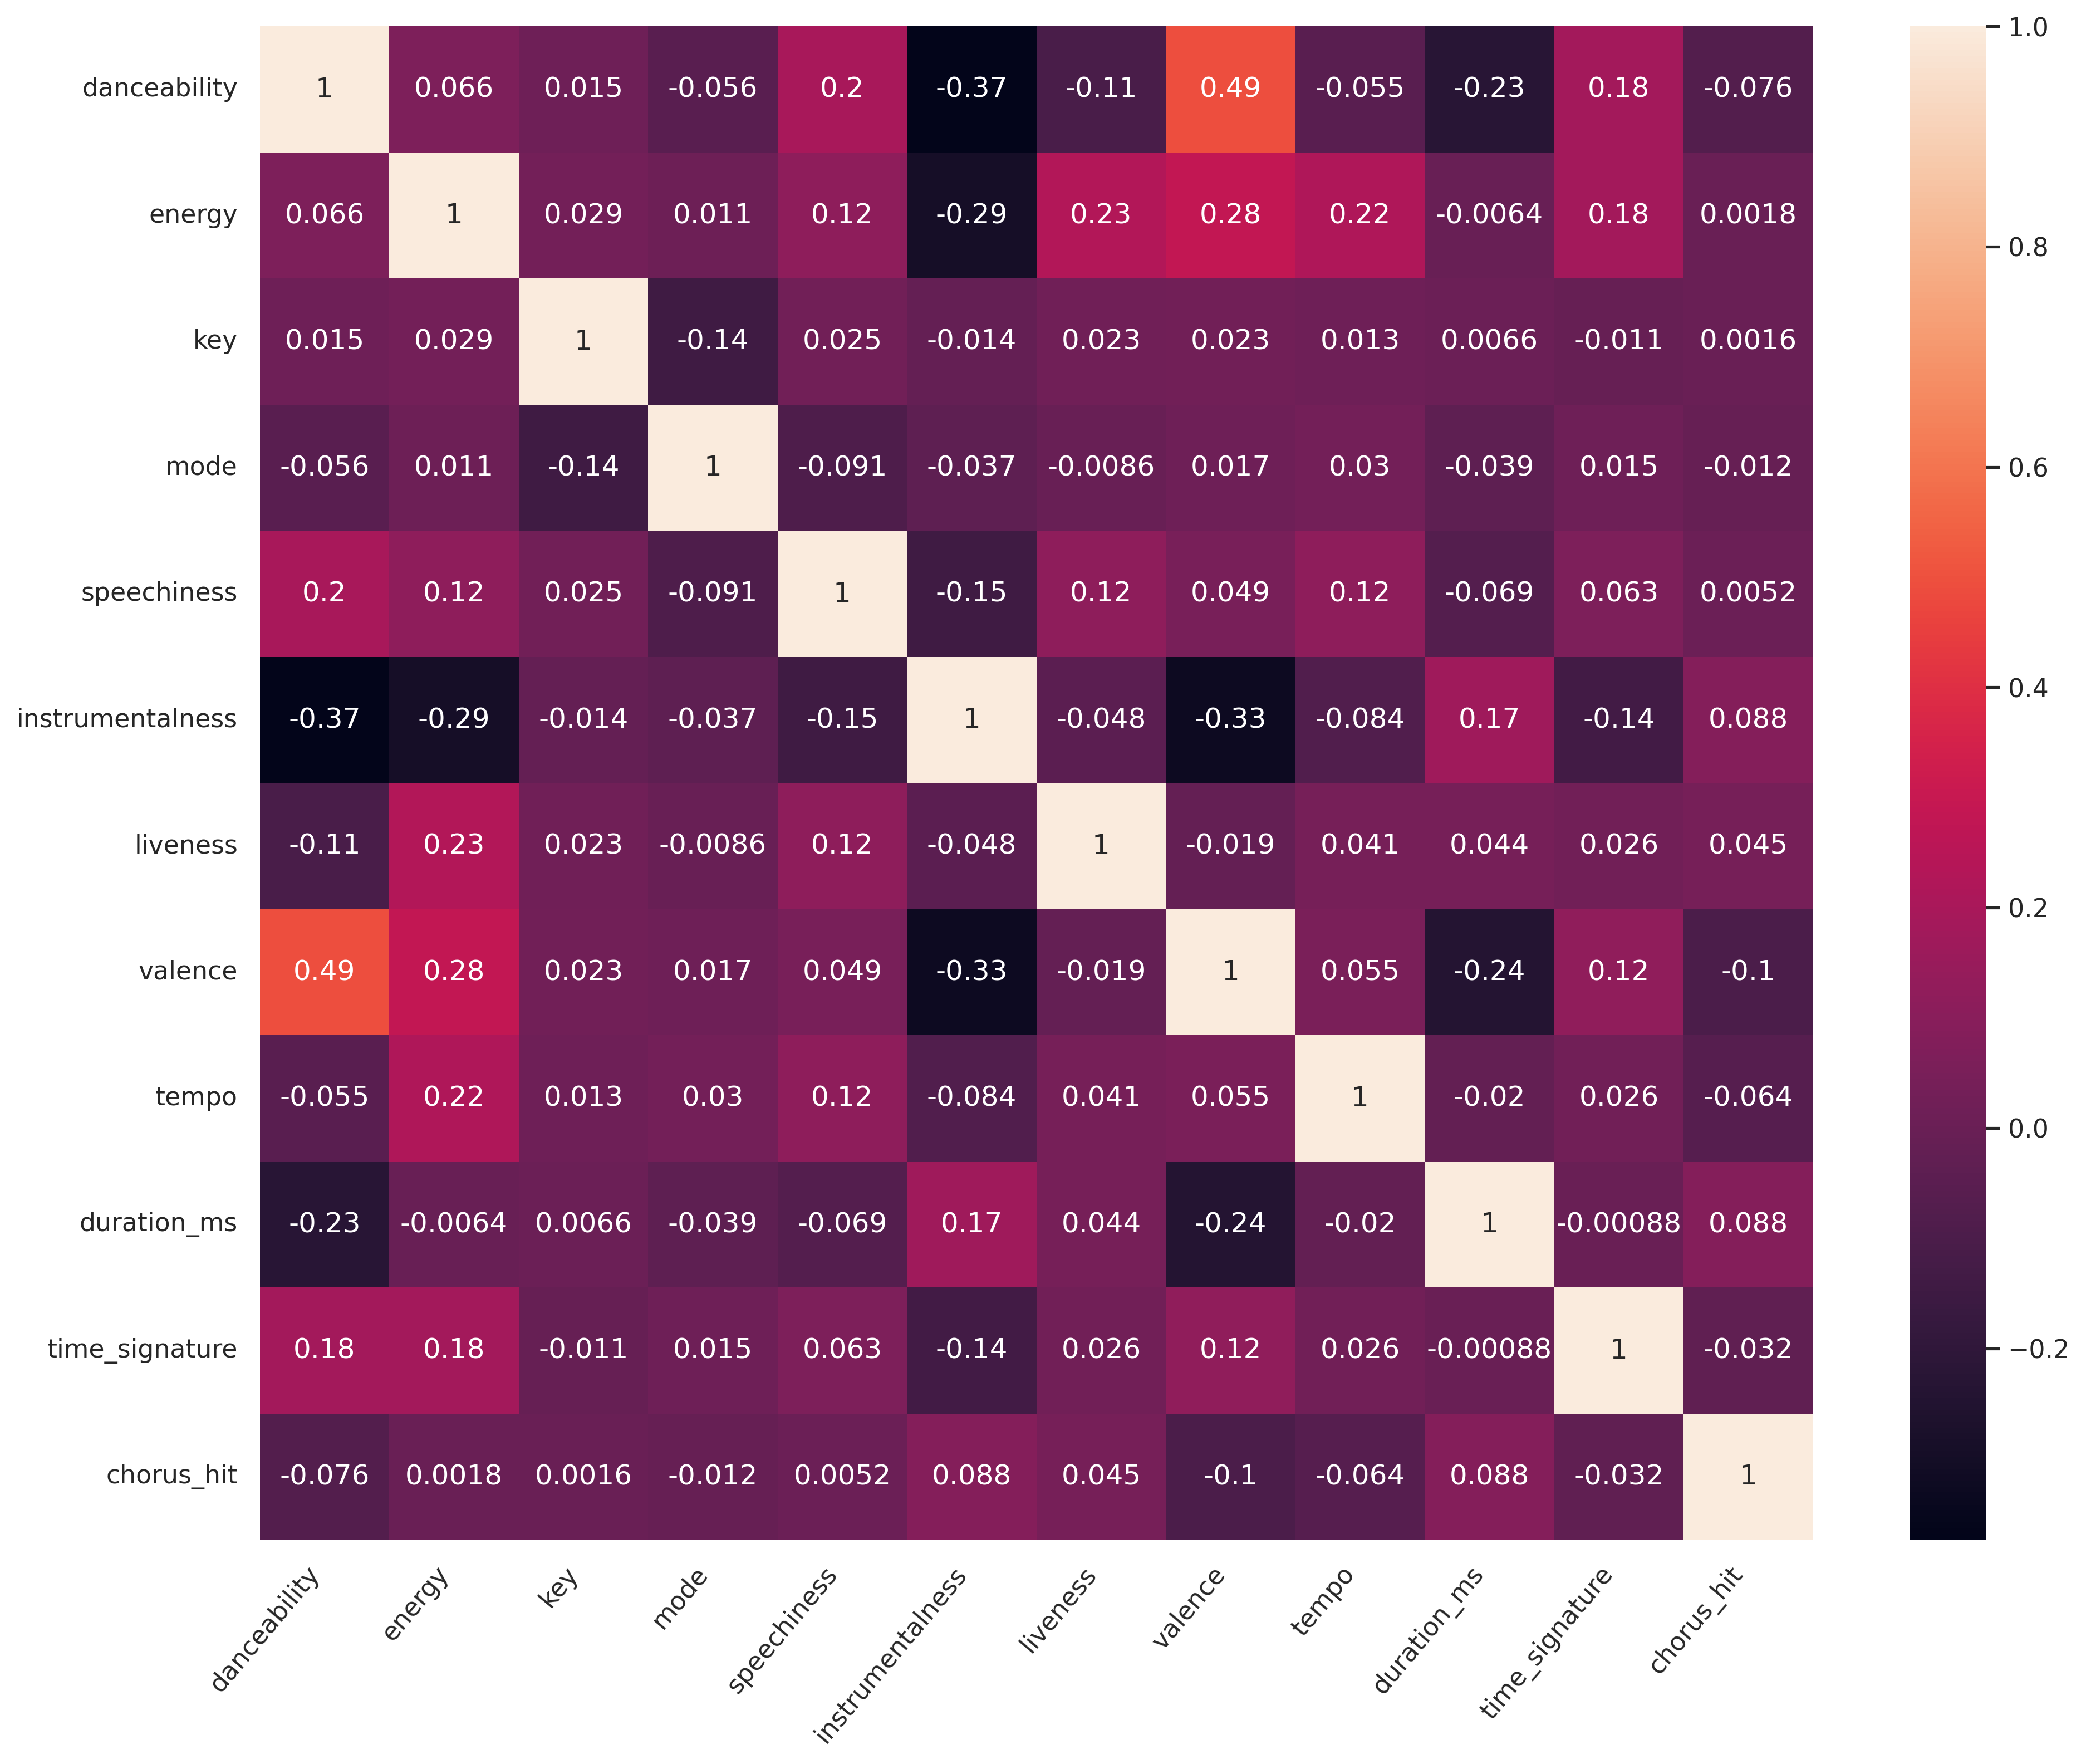

In [10]:
feats = ['danceability', 'energy', 'key', 'mode', 'speechiness',
         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
         'time_signature', 'chorus_hit']

plot_corr(df_db, feats)

<center><span style="font-size:14px"><b>Figure 5. </b>Correlation Plot of Track Features (Post-cleansing)</span></center>

**Insight:** The `mode`, `key`, and `time_signature` features are dropped due to their low feature importance based on previous modeling iterations. In particular,

- `mode` can be interpreted as a binarized proxy for valence.
- `key` is not necessarily a valid ordinal variable as it is cyclic across the musical scale.
- `time_signature` is extremely imbalanced towards 4/4 time signature.

[Back to TOC](#TContents)

<a id='Model'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">VI. MODEL SELECTION</h1>

After selecting the relevant features, the next step is to perform a grid search on different machine learning and perform hyperparameter tuning.

In [11]:
feats = ['danceability', 'energy', 'speechiness', 'instrumentalness',
         'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit']

split_dict = dict(test_size=0.25, random_state=1337)

In [12]:
(X_trainval, X_test,
 y_trainval, y_test) = get_feats_and_target(df_db, split_dict)

In [13]:
log_fn = FunctionTransformer(log_transform)
scaler = StandardScaler()
ros = SMOTE(sampling_strategy='minority', random_state=rng)
log_cols = ['speechiness', 'instrumentalness', 'liveness']
preprocessor = ColumnTransformer([('log', log_fn, log_cols)],
                                 remainder='passthrough')

pipe = Pipeline(
    [('prep', preprocessor),
     ('scaler', scaler),
     ('ros', ros),
     ('clf', GradientBoostingClassifier(random_state=rng))]
)

param_grid = [
#     {
#         'clf': [LogisticRegression(max_iter=1_000),
#                 LinearSVC(random_state=rng)],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__C': [0.05, 0.1, 5, 20]
#     },
    {
        'clf': [RandomForestClassifier(random_state=rng)],
        'clf__max_depth': [5, 8, 11],
        'clf__n_estimators': [120, 150]
    },
    {
        'clf': [GradientBoostingClassifier(random_state=rng)],
        'clf__max_depth': [5, 8, 11],
        'clf__n_estimators': [120, 150],
        'clf__learning_rate': [0.05, 0.15, 0.3]
    }
]

gs_params = dict(
    estimator=pipe,
    param_grid=param_grid,
    scoring=None,
    cv=5,
    return_train_score=True,
    refit=True,
    verbose=None,
    error_score='raise'
)

In [14]:
gs = run_ml(X_trainval, y_trainval, gs_params)
gs.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<function log_transform at 0x7f2c9b8d43a0>),
                                                  ['speechiness',
                                                   'instrumentalness',
                                                   'liveness'])])),
                ('scaler', StandardScaler()),
                ('ros',
                 SMOTE(random_state=RandomState(MT19937) at 0x7F2C94E4A240,
                       sampling_strategy='minority')),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.15, max_depth=5,
                                            n_estimators=120,
                                            random_state=RandomState(MT19937) at 0x7F2C94E4A440))])

In [15]:
get_scores(gs, X_test, y_test)

Train Accuracy: 96.92%
Validation Accuracy: 82.66%
Test Accuracy: 82.28%


In [16]:
gs.best_params_

{'clf': GradientBoostingClassifier(learning_rate=0.15, max_depth=5, n_estimators=120,
                            random_state=RandomState(MT19937) at 0x7F2C84A96E40),
 'clf__learning_rate': 0.15,
 'clf__max_depth': 5,
 'clf__n_estimators': 120}

Based on the grid search on the predefined hyperparameter space, the best classifier model with an $82.28\%$ test accuracy is:<br>
- `GradientBoostingClassifier` with 
    - `learning_rate` = $0.15$,
    - `max_depth` = $5$, and
    - `n_estimators` of $120$.
    

[Back to TOC](#TContents)

<a id='Results'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">VII. RESULTS AND DISCUSSION</h1>

<a id='SHAP'></a>
<h2 style="color:#3C89F3">A. SHAP: Global Explanation</h2> 

SHAP is a post-hoc model-agnostic explainability method that accounts for feature importance using their expected marginal contribution. Below is a global explanation for the best model using `shap`.

Exact explainer: 201it [00:23,  5.78it/s]                         


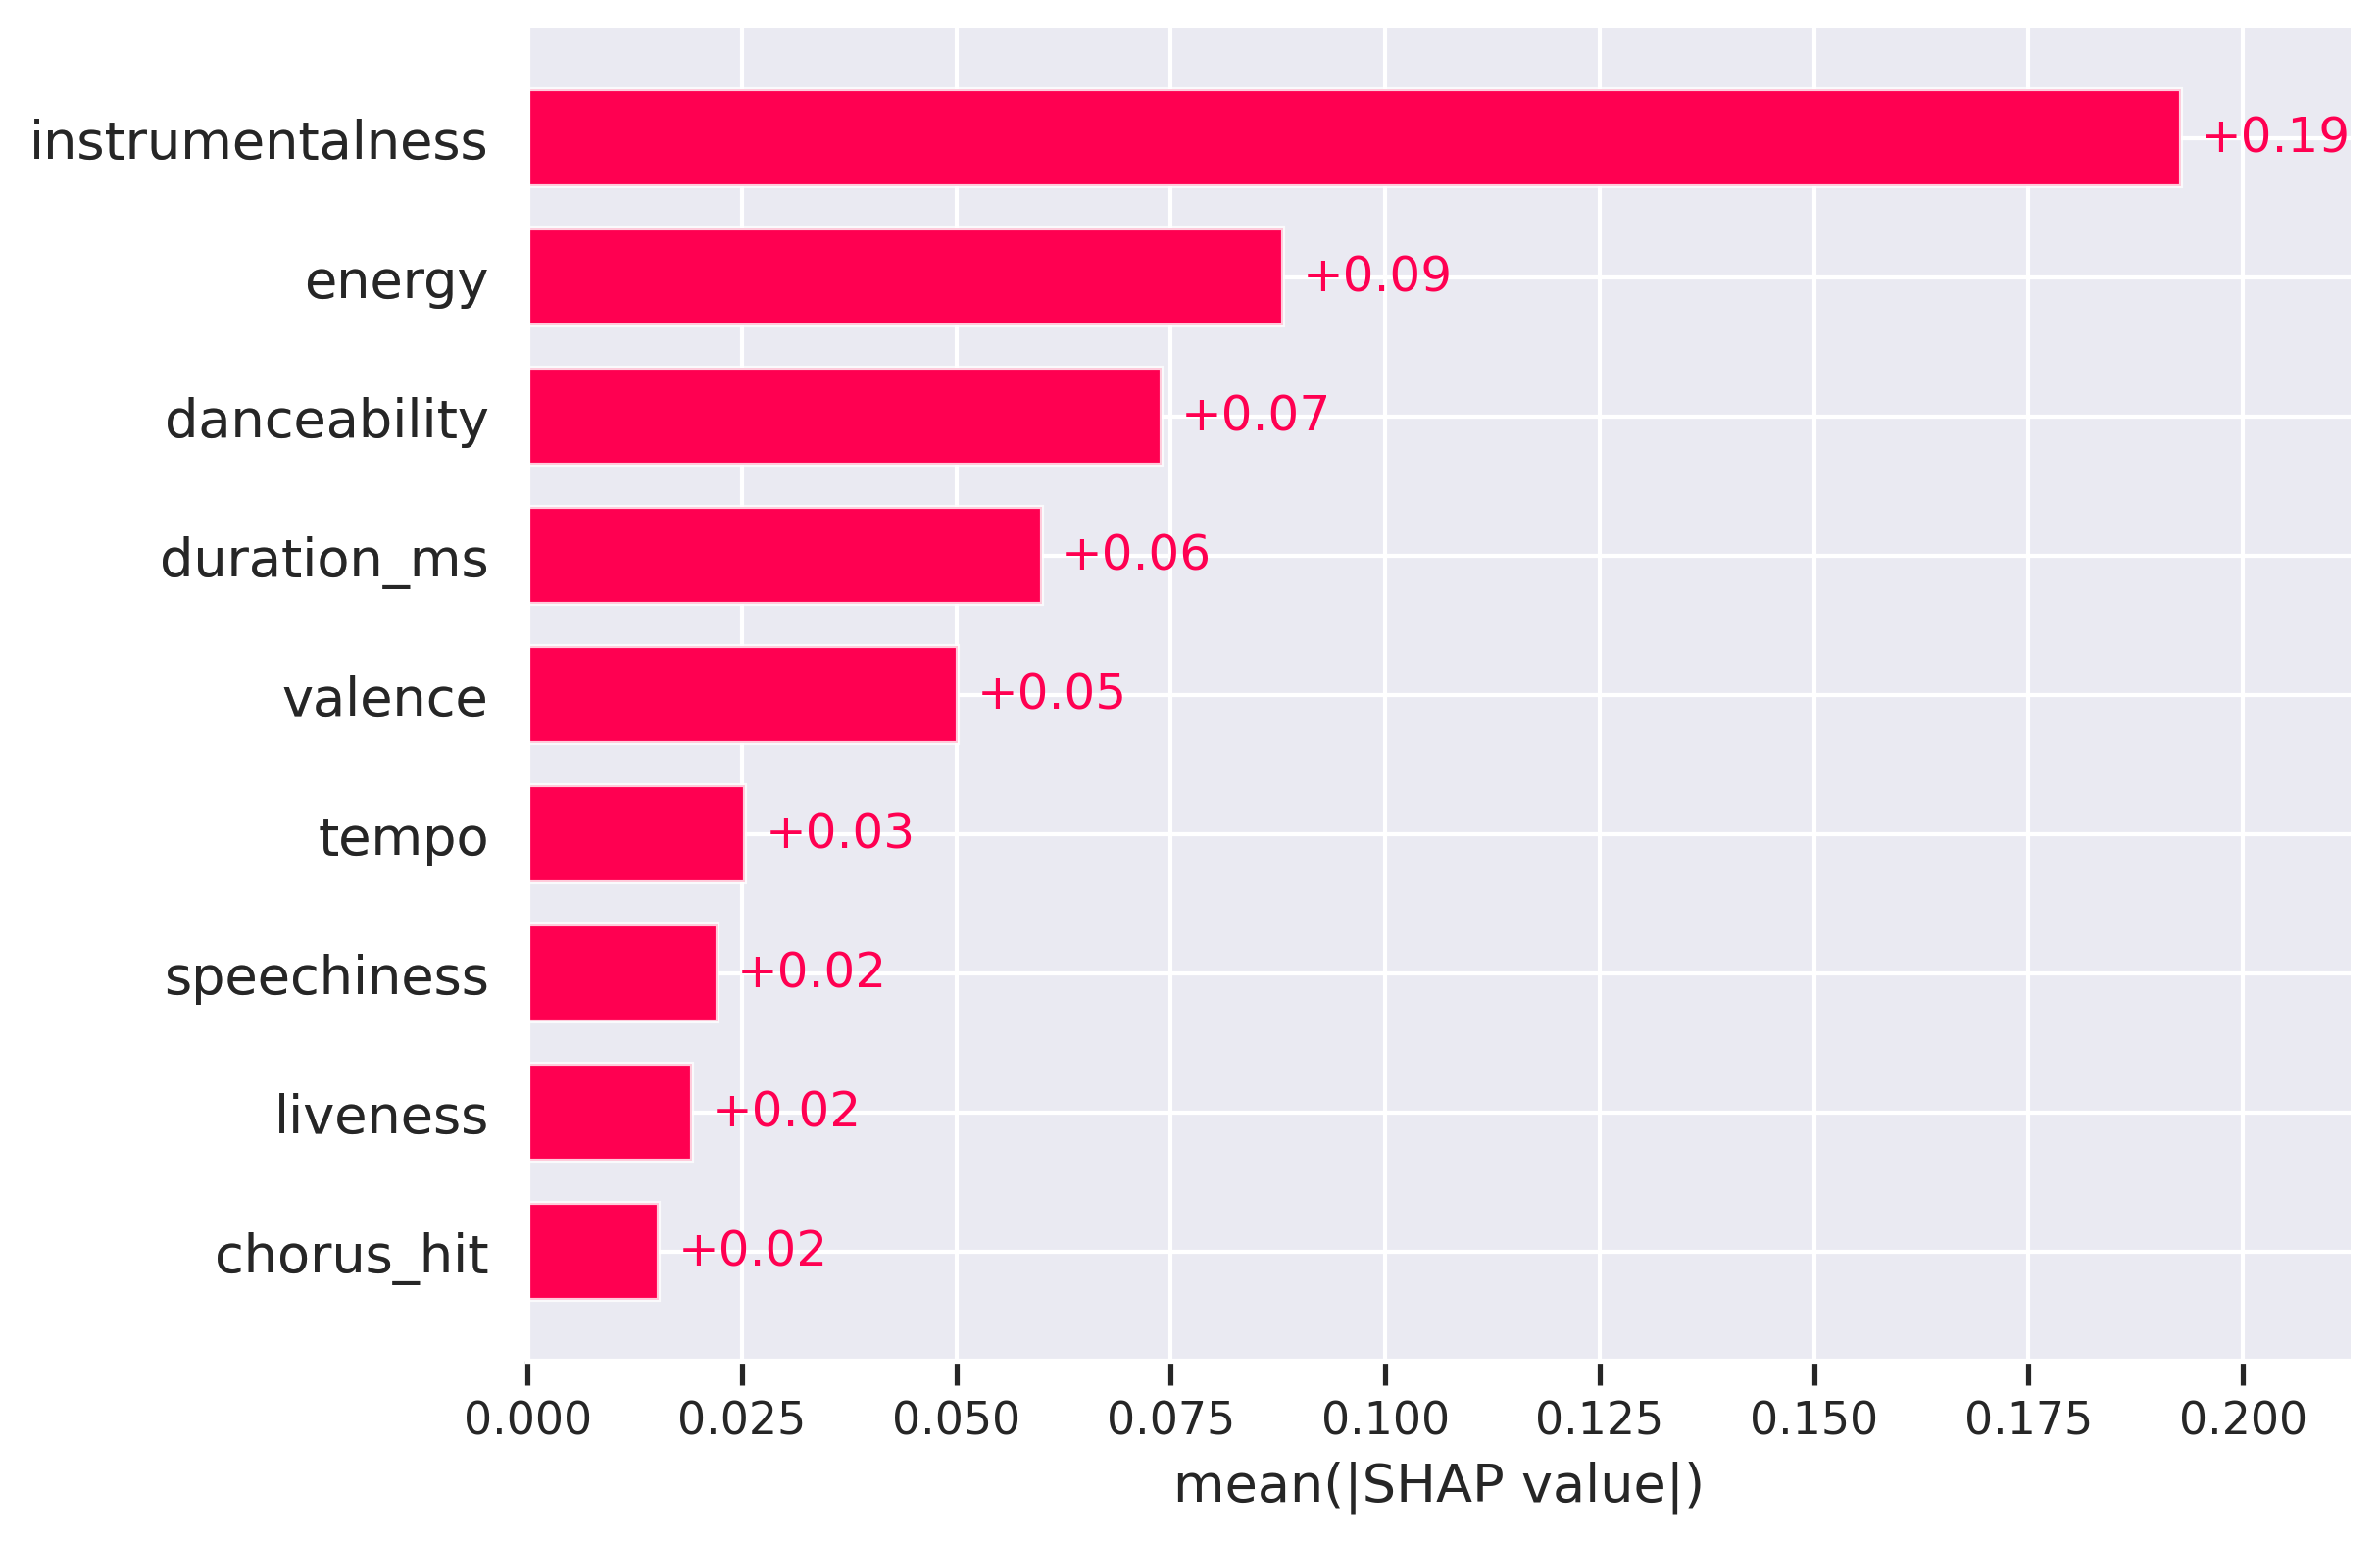

In [17]:
# Global explanation
shap_explainer = shap.Explainer(gs.predict_proba,
                                X_trainval,
                                feature_names=X_trainval.columns)

shap_values = shap_explainer(X_test.iloc[:200])

shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X_trainval.columns)

#(shap_explanation, plot_type='bar', plot_size=(14, 8), color='#ff0053')
shap.plots.bar(shap_explanation)

<center><span style="font-size:14px"><b>Figure 6. </b>SHAP Summary Bar Plot for Global Explanation</span></center>

**Insight:** For the years 2010-2019, `instrumentalness`, `energy`, and `danceability` generally contribute the most to the outcome of the model.


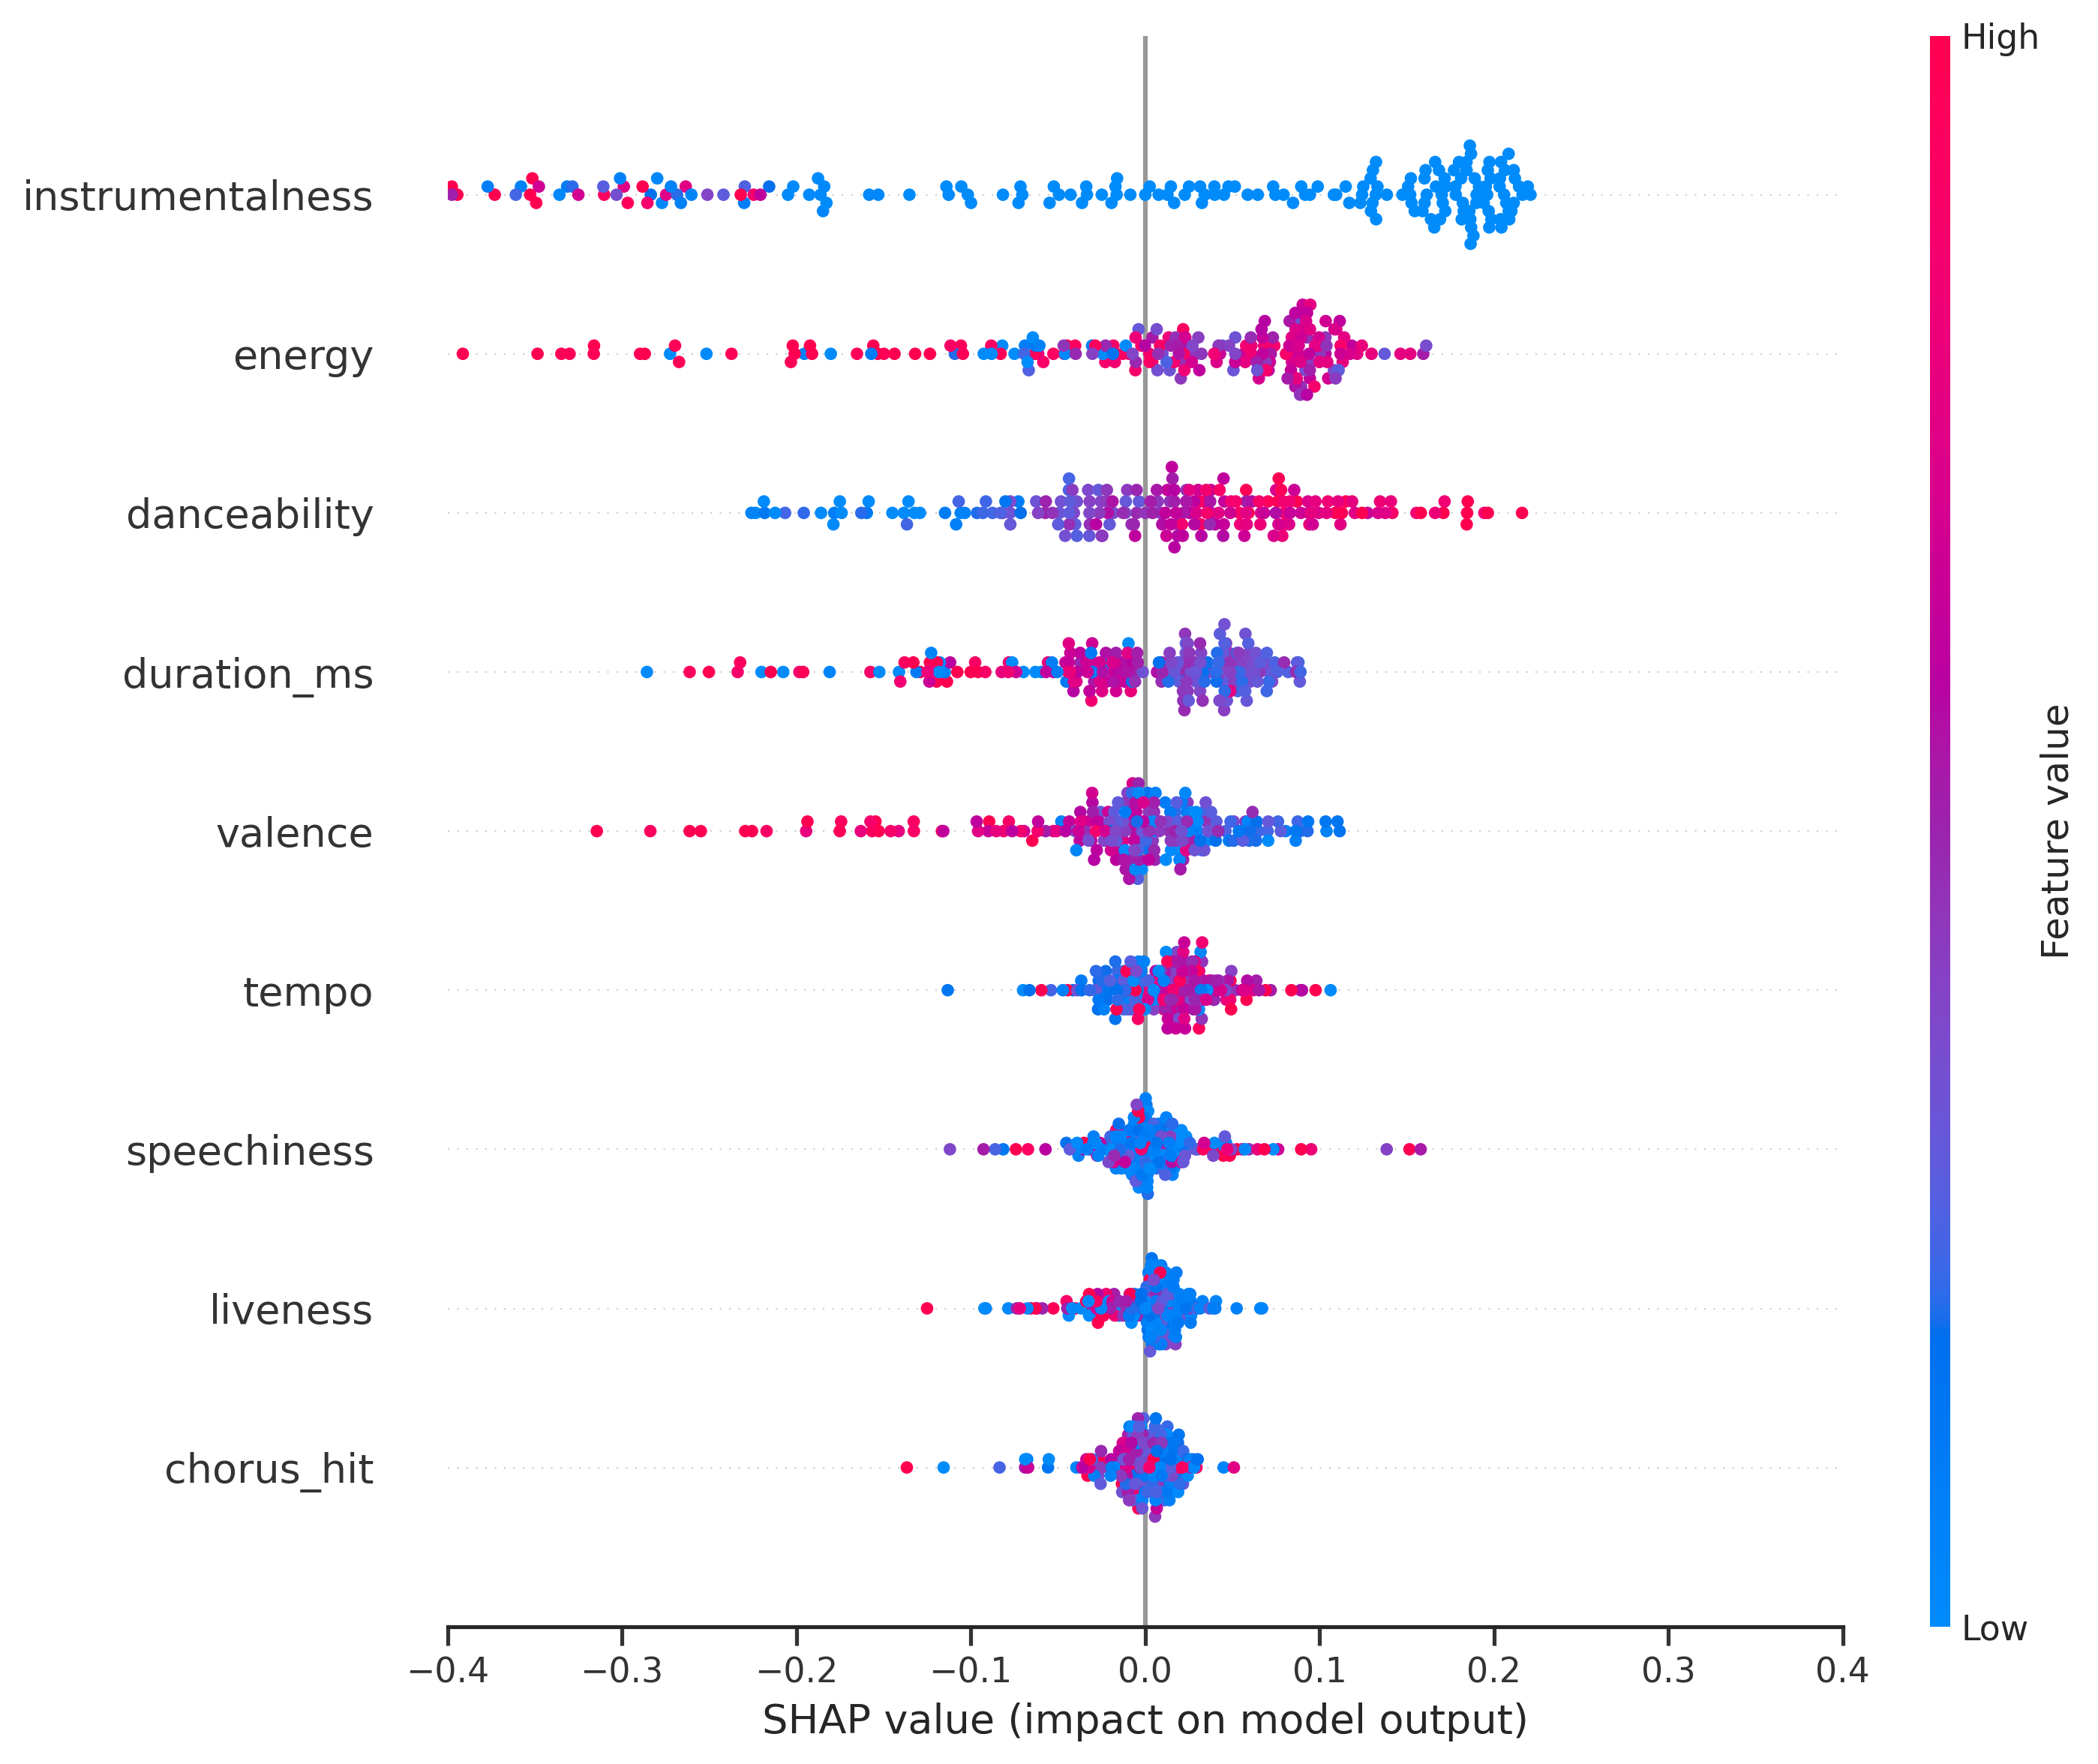

In [18]:
xlim = (-0.4, 0.4)

with sns.axes_style('white'):
    shap.summary_plot(shap_explanation, plot_size=(10, 8), show=False)
    ax = plt.gca()
    ax.set_xlim(*xlim)
    plt.show()

<center><span style="font-size:14px"><b>Figure 7. </b>SHAP Beeswarm Plot for Global Explanation</span></center>

**Insight:** For the years 2010-2019, the general trend of hit tracks are danceable, upbeat, but moody, with minimal instrumental solos.


<a id='DiCE'></a>
<h2 style="color:#3C89F3">B. DiCE: Global Explanation</h2> 

DiCE (Diverse Counterfactual Explanations) explores possibilities using minimal changes for all or for some features to arrive at a desired outcome. Below is an explanation of the global feature importance of the model using `dice_ml`.

In [19]:
model = Model(model=gs, backend='sklearn')
dice_data = Data(
    dataframe=X_trainval.join(y_trainval),
    continuous_features=X_trainval.columns.tolist(),
    outcome_name='target')
dice_exp = Dice(dice_data, model, method='genetic')

In [20]:
global_feat_importance = dice_exp.global_feature_importance(
    X_trainval[y_trainval == 1].iloc[:50]
)

100%|██████████| 50/50 [00:08<00:00,  5.59it/s]


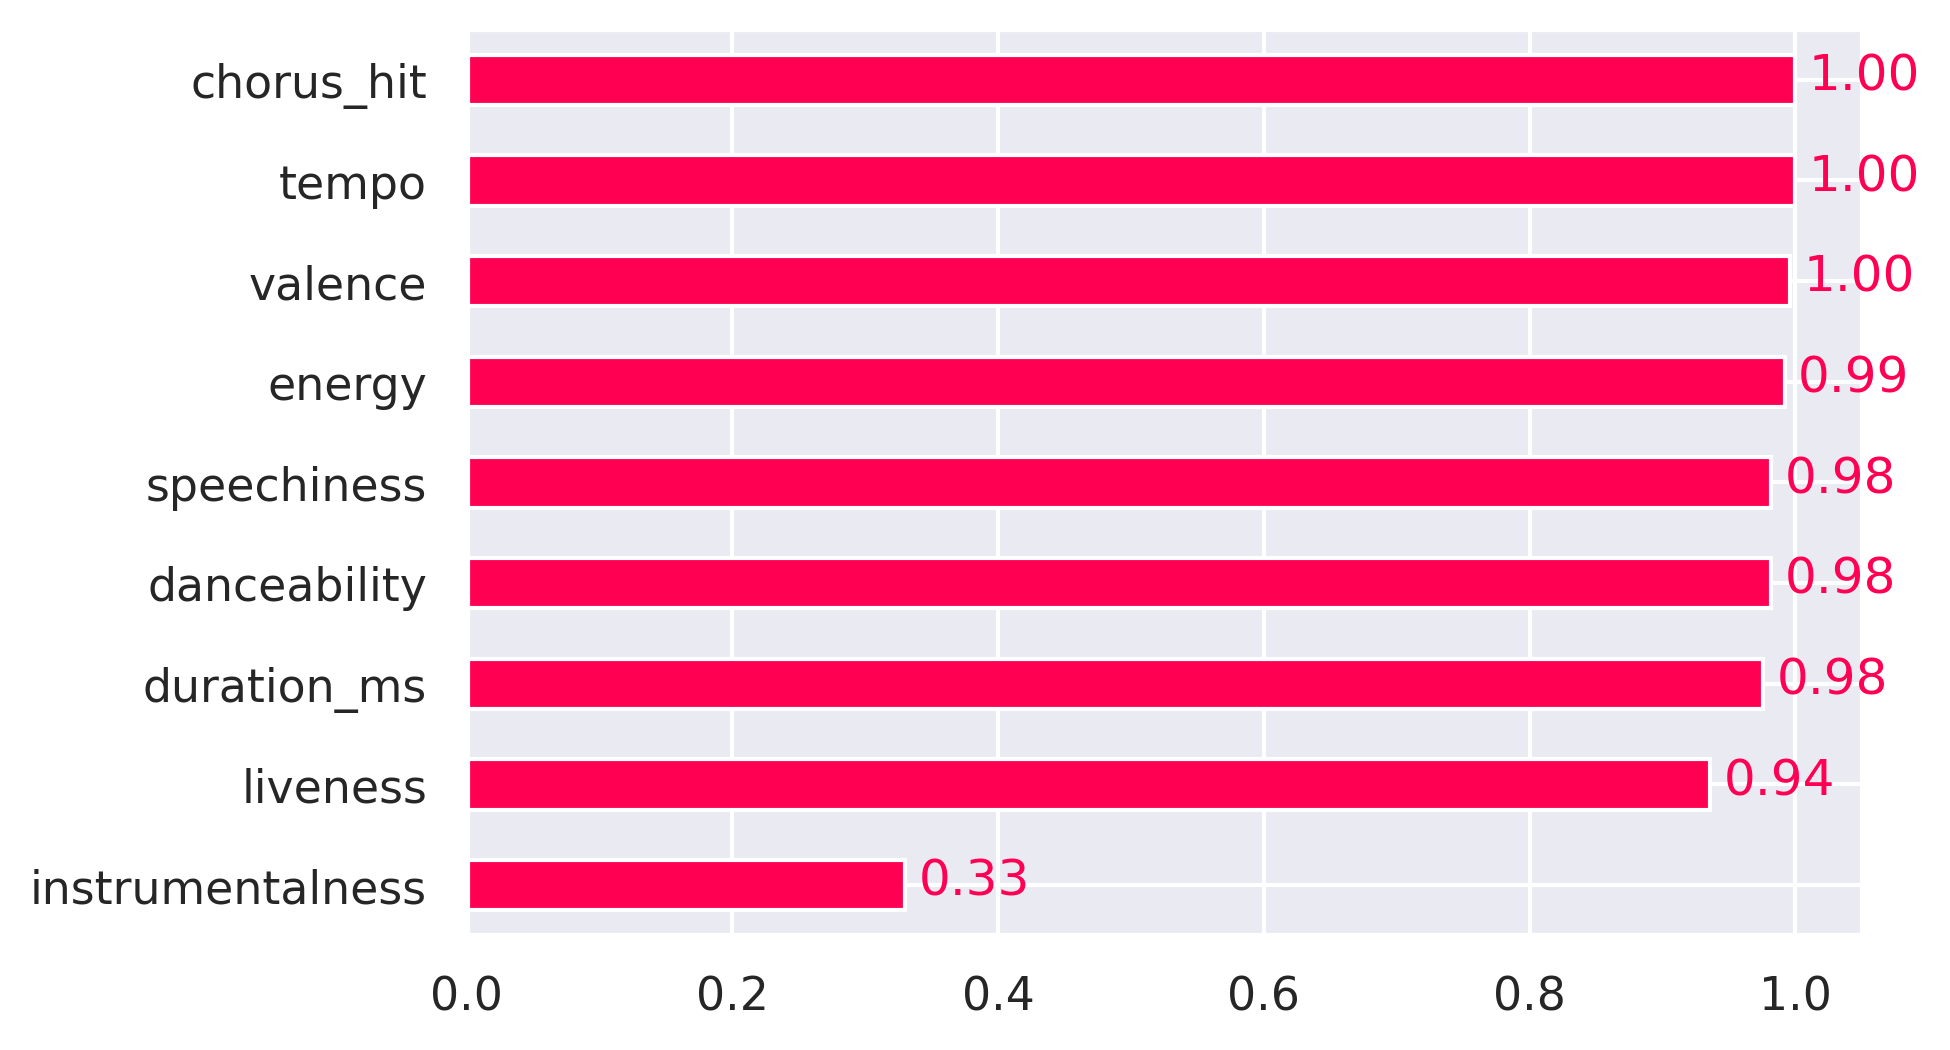

In [21]:
global_counterfactuals = pd.Series(global_feat_importance.summary_importance)

fig, ax = plt.subplots()
global_counterfactuals.sort_values().plot(kind='barh', ax=ax, color='#ff0053')

# Add the values to the plot
for i, v in enumerate(global_counterfactuals.sort_values()):
    ax.text(v + 0.01, i - 0.1, f'{v:.2f}', color='#ff0053')
plt.show()

<center><span style="font-size:14px"><b>Figure 8. </b>DiCE Feature Importance Plot for Global Explanation</span></center>

**Insight:** Generally speaking, for songs released in the years 2010-2019, the features which are the most frequently changed to flip the success or failure of a song are `chorus_hit`, `tempo`, `duration_ms`, `valence`, `danceability`, `energy`, `speechiness`, and `liveliness`. However, most of these changes are minute or marginal.

<a id='Demo_01'></a>
<h2 style="color:#3C89F3">C. Demo_01: Hit</h2> 

In this section, the team used `shap` to explain why a song was predicted to be a hit by the model.

In [22]:
Demo_01 = 6260
client = X_test.loc[[Demo_01]]
df_db.loc[client.index]

track        artist                                   uri  \
6260  Shake It Off  Taylor Swift  spotify:track:5xTtaWoae3wi06K5WfVUUH   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
6260         0.648   0.785    7    -5.414     1        0.165        0.0561   

      instrumentalness  liveness  valence   tempo  duration_ms  \
6260               0.0     0.148    0.943  160.02       219200   

      time_signature  chorus_hit  sections  target  
6260               4    48.31277        10       1

In [23]:
gs.predict(X_test.loc[[Demo_01]])

array([1])

In [24]:
gs.predict_proba(X_test.loc[[Demo_01]])

array([[0.0810835, 0.9189165]])

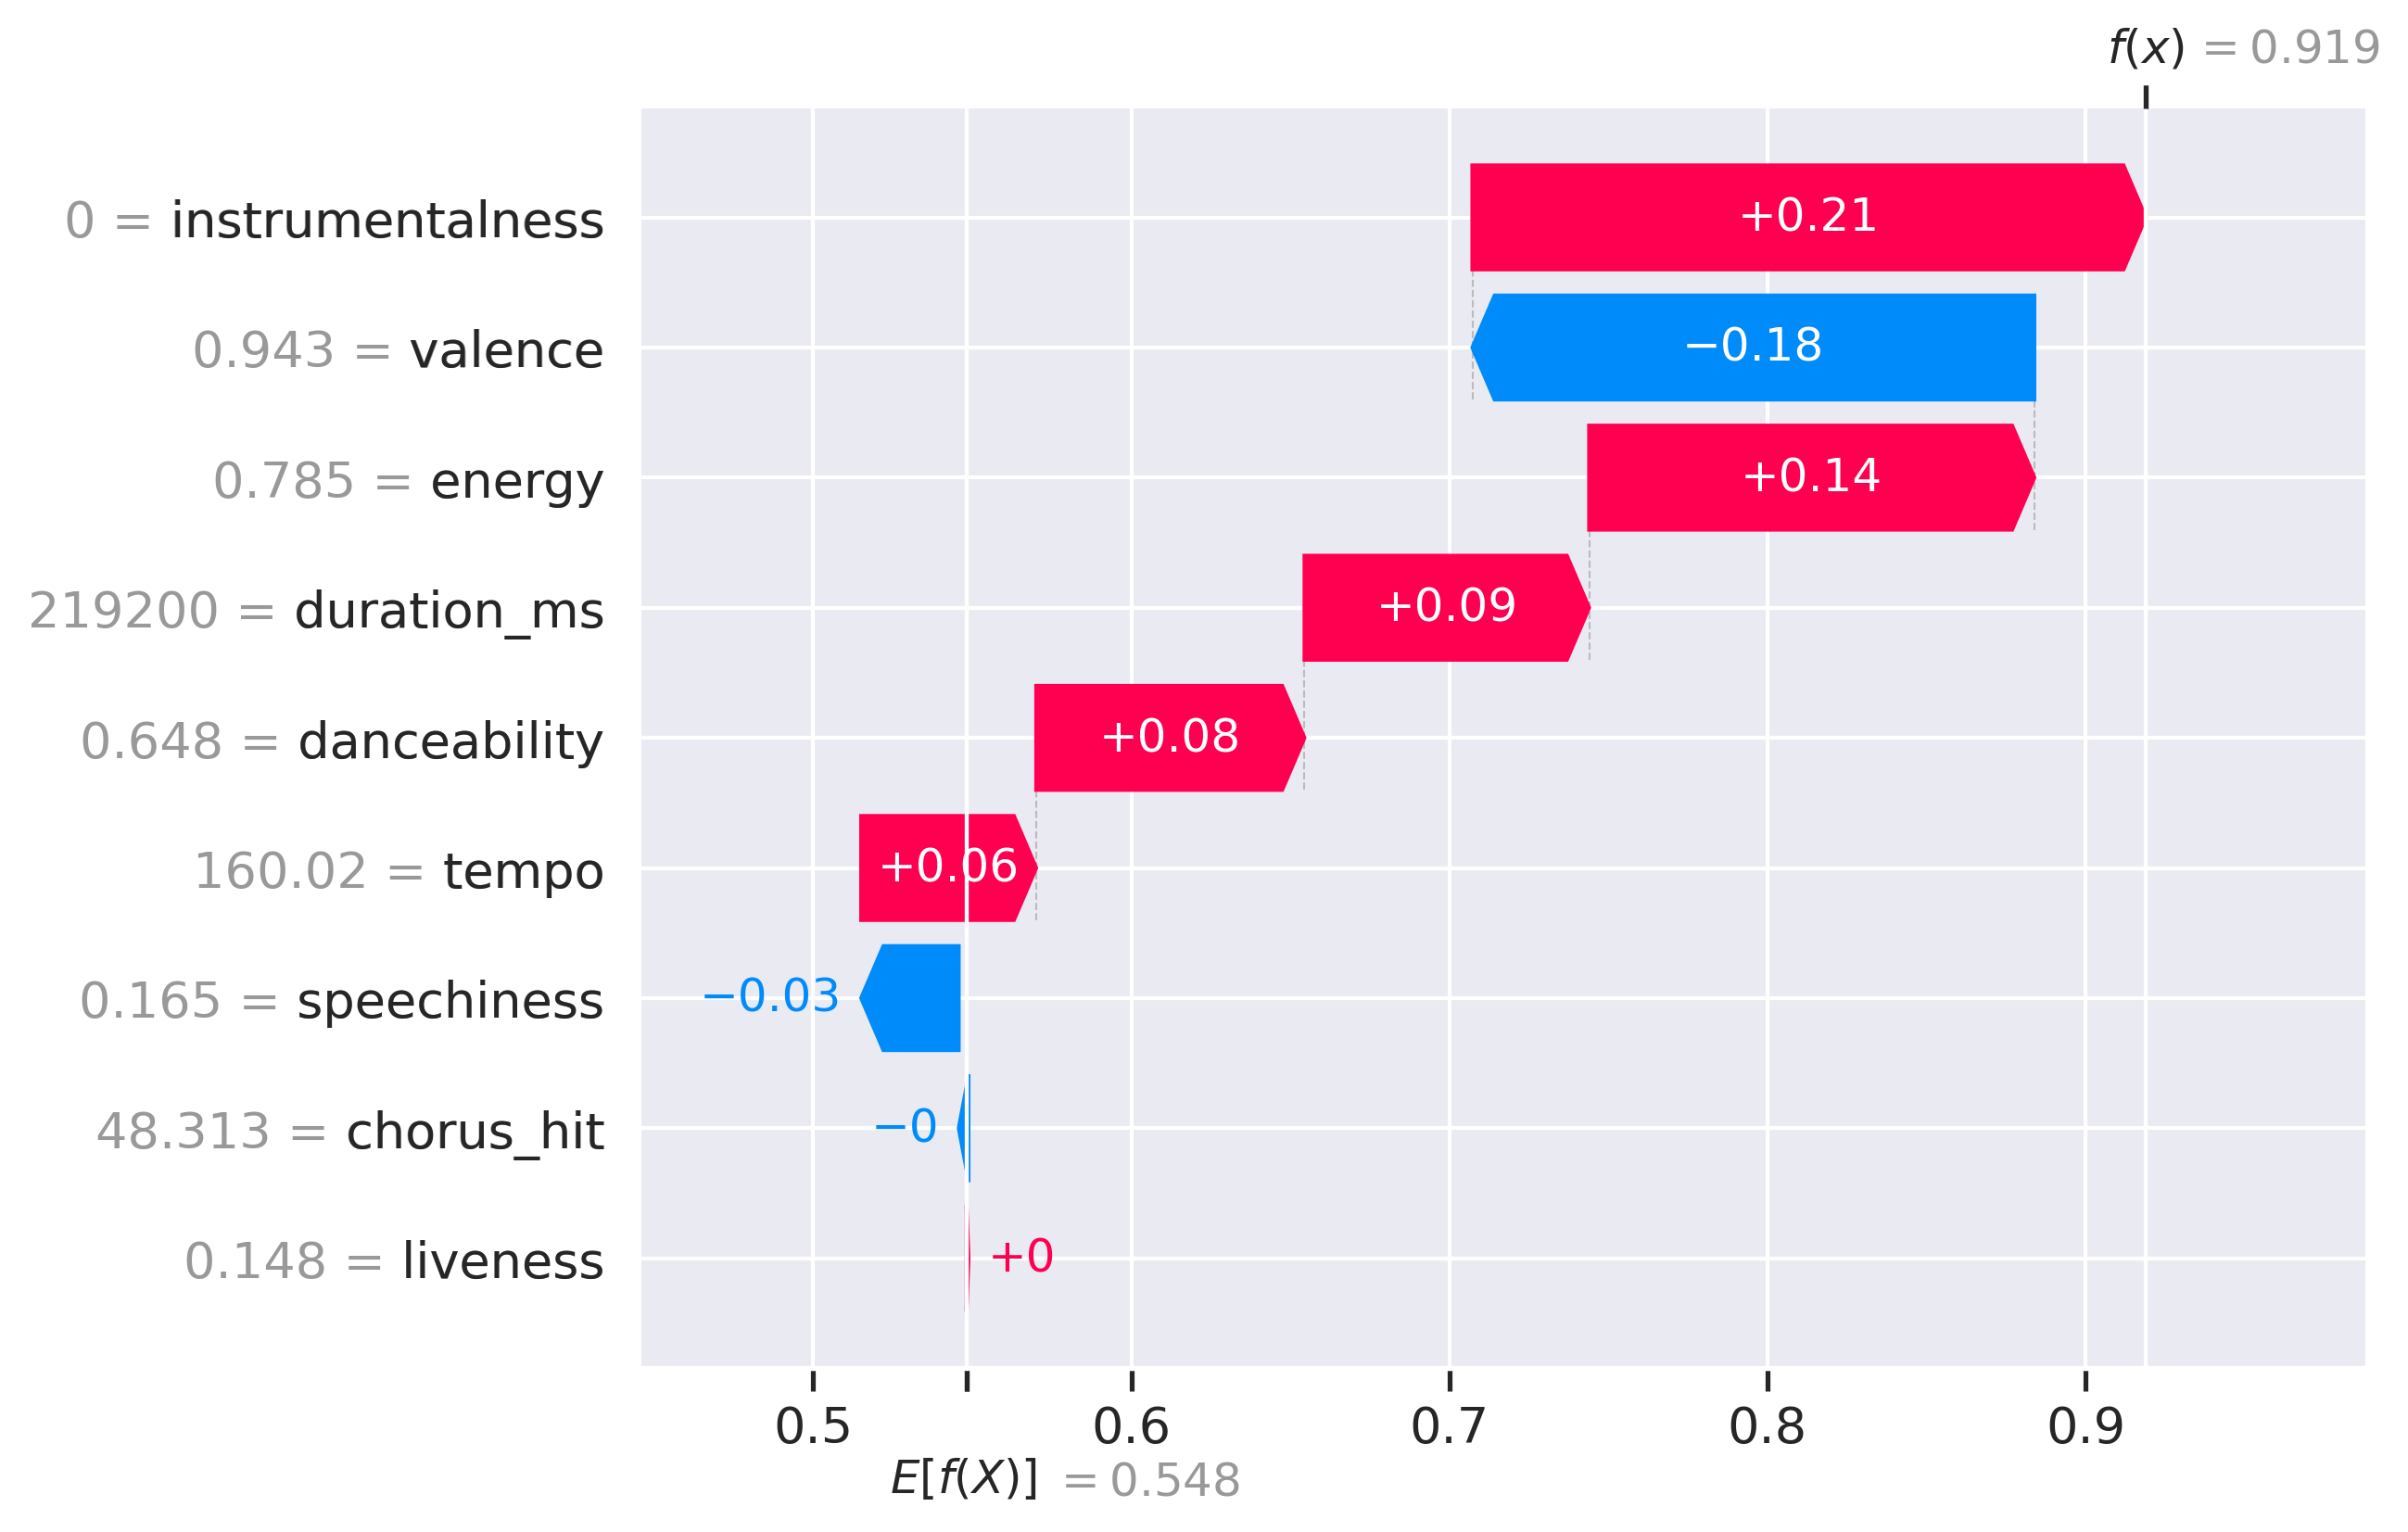

In [25]:
client_shap_values = shap_explainer(client)
client_shap_explanation = shap.Explanation(
    client_shap_values.values[:, :, 1],
    client_shap_values.base_values[0][1],
    client_shap_values.data,feature_names=X_trainval.columns
)
shap.plots.waterfall(client_shap_explanation[0])

<center><span style="font-size:14px"><b>Figure 9. </b>Demo_01: SHAP Waterfall Plot for Local Explanation</span></center>

**Insight:** Top positive contributors are `instrumentalness`, `energy`, and `danceability`, and `duration_ms`. The model would have liked it better to turn down `valence` just by a small amount, but this does not significantly affect the outcome.

<a id='Demo_02'></a>
<h2 style="color:#3C89F3">D. Demo_02: Flop</h2> 

In this section, the team used `shap` to explain why a song was predicted to be a flop by the model. Moreover, the team used `dice_ml` to generate counterfactuals for the said flop song and determine what is the smallest change that will make the song a hit.

In [26]:
Demo_02 = 6211
client = X_test.loc[[Demo_02]]
df_db.loc[client.index]

track       artist                                   uri  \
6211  Space Song  Beach House  spotify:track:0hNhlwnzMLzZSlKGDCuHOo   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
6211         0.509    0.79    0    -7.105     0       0.0293         0.218   

      instrumentalness  liveness  valence    tempo  duration_ms  \
6211             0.125     0.144    0.625  147.073       320467   

      time_signature  chorus_hit  sections  target  
6211               4    42.85968        11       0

In [27]:
gs.predict(X_test.loc[[Demo_02]])

array([0])

In [28]:
gs.predict_proba(X_test.loc[[Demo_02]])

array([[0.91729293, 0.08270707]])

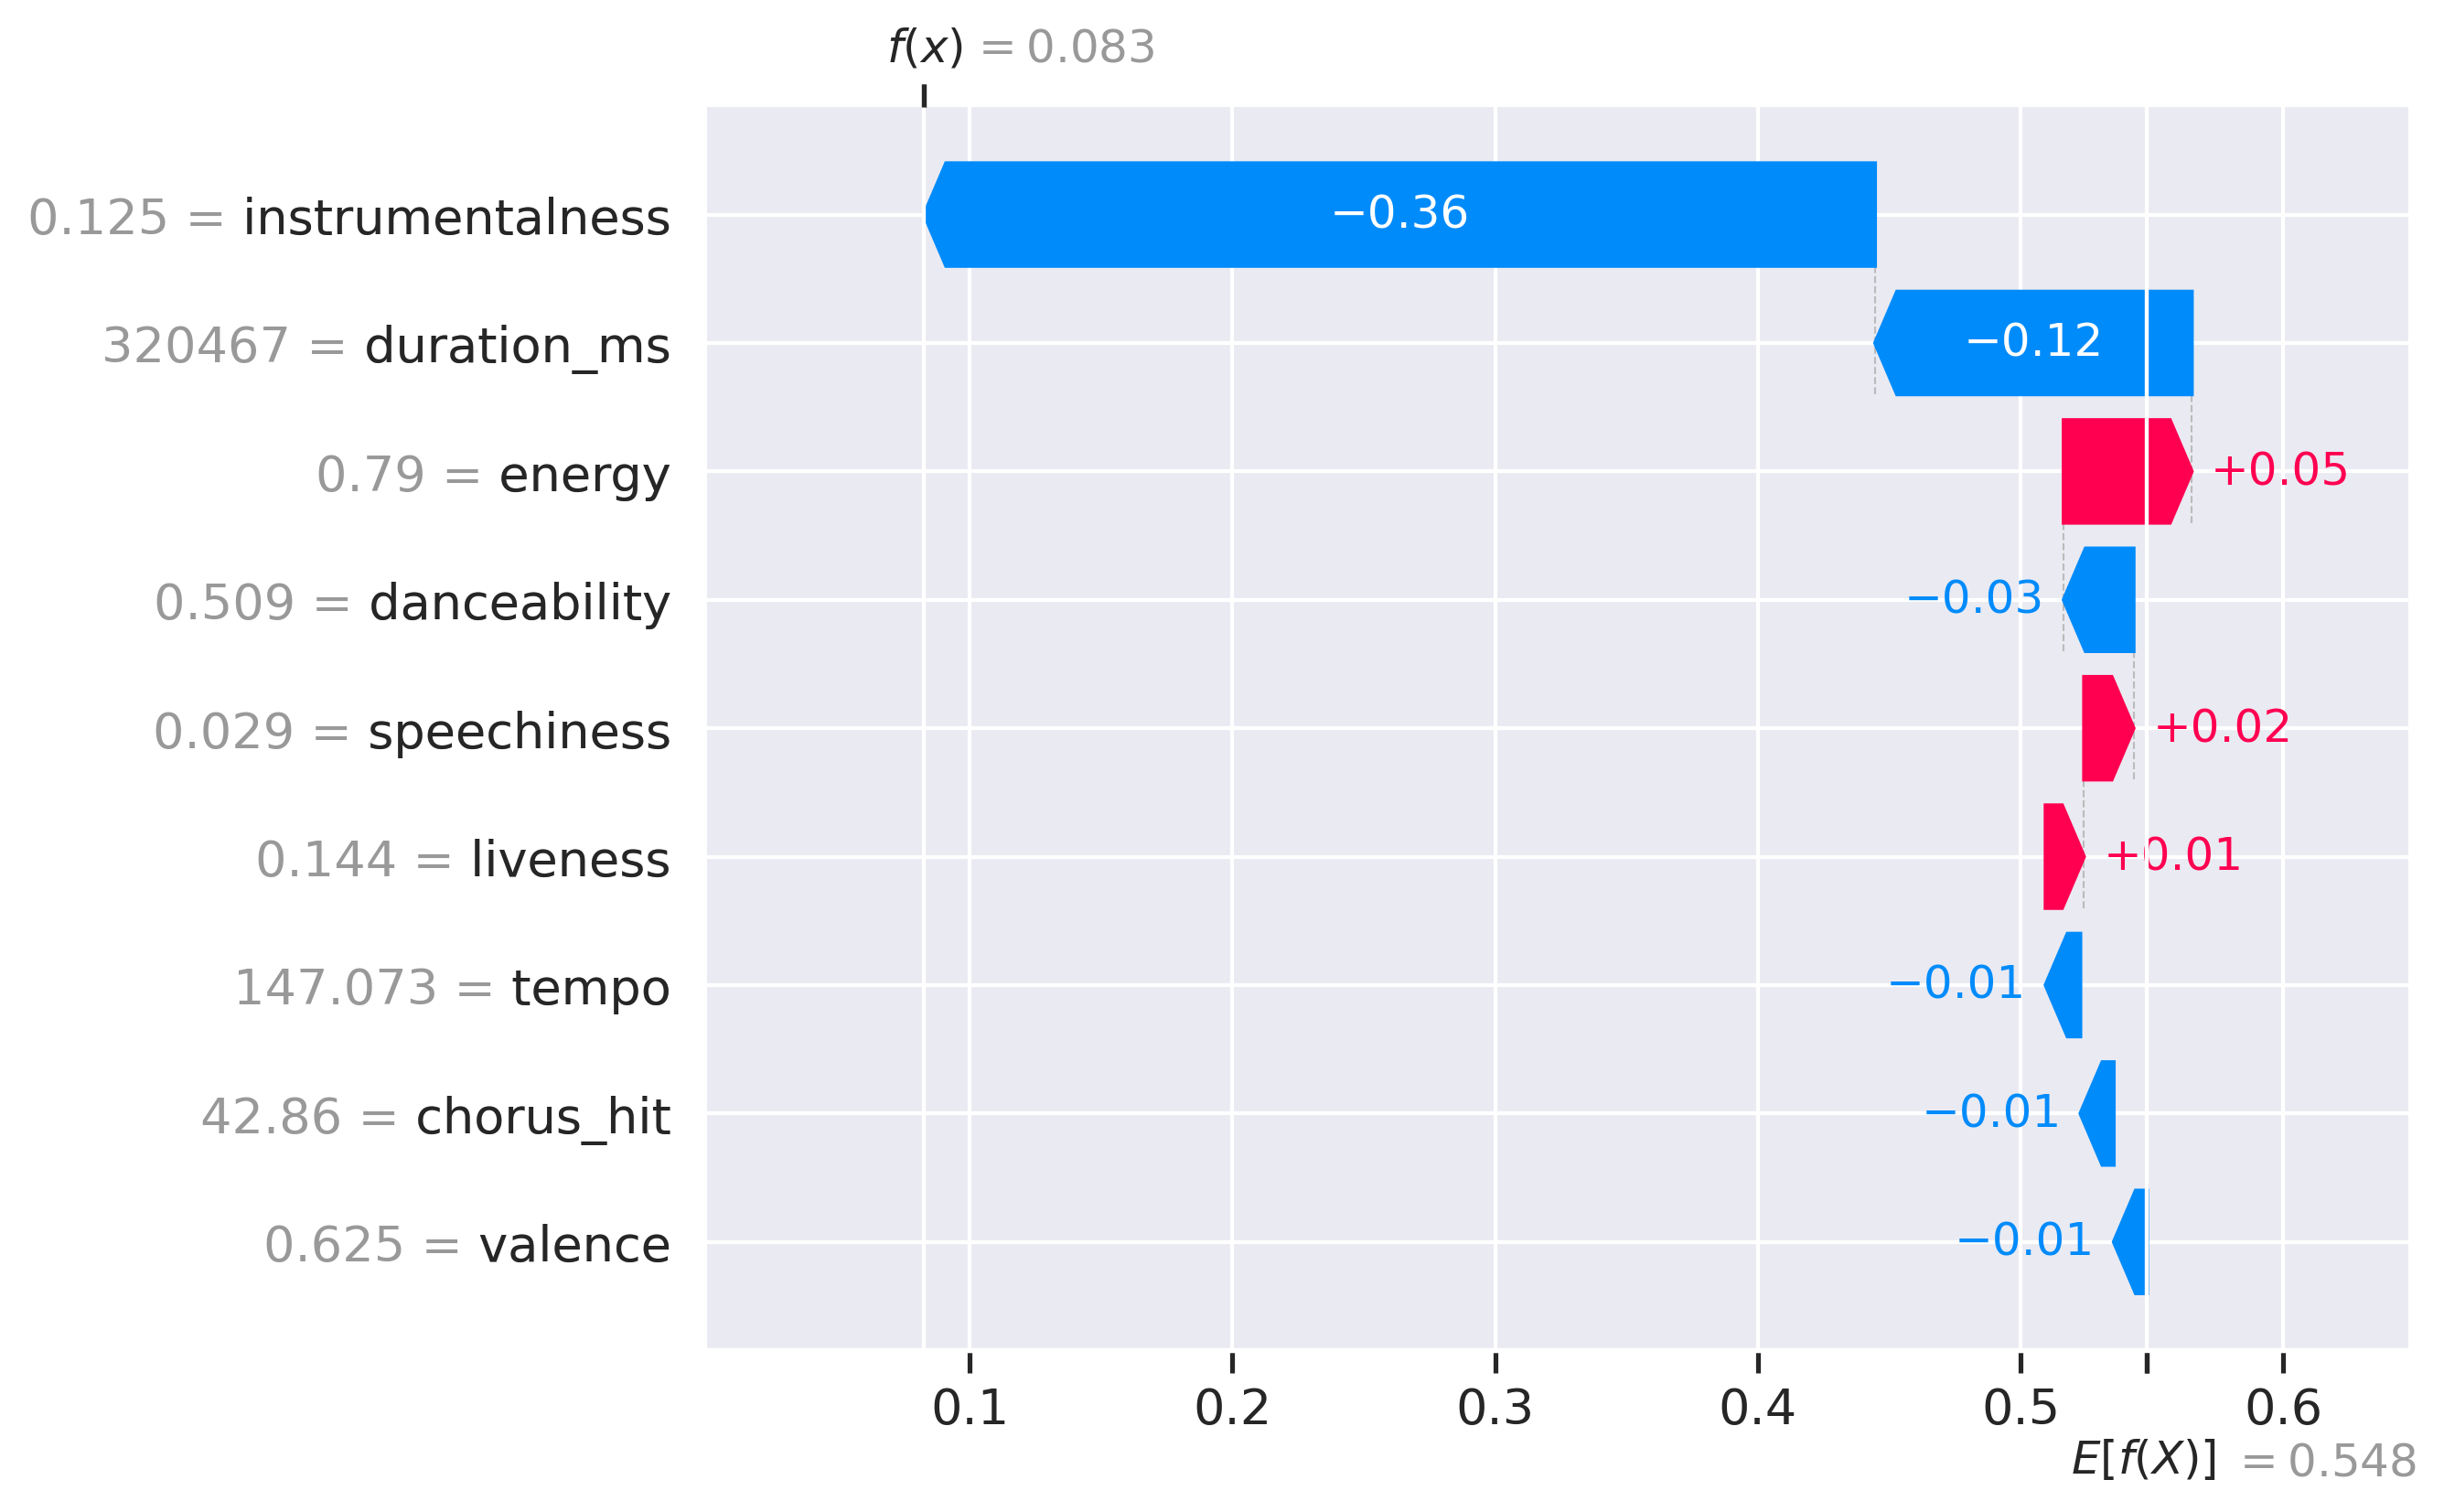

In [29]:
client_shap_values = shap_explainer(client)
client_shap_explanation = shap.Explanation(
    client_shap_values.values[:, :, 1],
    client_shap_values.base_values[0][1],
    client_shap_values.data,feature_names=X_trainval.columns
)
shap.plots.waterfall(client_shap_explanation[0])

<center><span style="font-size:14px"><b>Figure 10. </b>Demo_02: SHAP Waterfall Plot for Local Explanation</span></center>

**Insight:** For Space Song, on the other hand, the song was too instrumental and a bit too long, according to the model. The remaining features had too little influence on the outcome of the song.

In [30]:
model = Model(model=gs, backend='sklearn')
dice_data = Data(
    dataframe=X_trainval.join(y_trainval),
    continuous_features=X_trainval.columns.tolist(),
    outcome_name='target')
dice_exp = Dice(dice_data, model, method='genetic')

In [31]:
features_to_vary = ['danceability', 'valence', 'instrumentalness', 'tempo']

cfes2 = dice_exp.generate_counterfactuals(
    client,
    total_CFs=50,
    desired_class='opposite',
    features_to_vary=features_to_vary
)
cfes2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

Query instance (original outcome : 0)


danceability  energy  speechiness  instrumentalness  liveness  valence  \
0         0.509    0.79       0.0293             0.125     0.144    0.625   

        tempo  duration_ms  chorus_hit  target  
0  147.072998     320467.0    42.85968       0


Diverse Counterfactual set (new outcome: 1)


danceability energy speechiness instrumentalness liveness valence    tempo  \
0        0.708   0.79      0.0293              0.0    0.144       -   148.14   
0        0.509   0.79      0.0293              0.0    0.144   0.176    128.0   
0        0.866   0.79      0.0293              0.0    0.144       -  118.523   
0          0.7   0.79      0.0293              0.0    0.144   0.197   91.959   
0        0.826   0.79      0.0293              0.0    0.144   0.138  103.002   
0        0.628   0.79      0.0293              0.0    0.144   0.096  124.791   
0        0.587   0.79      0.0293              0.0    0.144     0.0  124.791   
0        0.536   0.79      0.0293              0.0    0.144   0.097  131.988   
0         0.72   0.79      0.0293              0.0    0.144   0.212   142.98   
0        0.838   0.79      0.0293              0.0    0.144   0.204   122.99   
0        0.681   0.79      0.0293              0.0    0.144   0.066   97.993   
0        0.706   0.79      0.0293              0.0    0.144    0.26    104.0   
0        0.706   0.79      0.0293              0.0    0.144   0.684  128.011   
0        0.472   0.79      0.0293              0.0    0.144   0.376   39.369   
0        0.378   0.79      0.0293              0.0    0.144   0.376    123.7   
0        0.309   0.79      0.0293              0.0    0.144   0.376  195.815   
0        0.309   0.79      0.0293              0.0    0.144    0.37  177.913   
0        0.309   0.79      0.0293              0.0    0.144    0.37  195.815   
0         0.59   0.79      0.0293              0.0    0.144    0.15  195.815   
0        0.309   0.79      0.0293              0.0    0.144     0.0  131.242   
0        0.306   0.79      0.0293              0.0    0.144     0.0   39.369   
0        0.062   0.79      0.0293              0.0    0.144   0.376  195.815   
0        0.062   0.79      0.0293              0.0    0.144    0.37  195.815   
0        0.484   0.79      0.0293              0.0    0.144   0.216  120.066   
0        0.504   0.79      0.0293              0.0    0.144   0.262   99.982   
0        0.504   0.79      0.0293              0.0    0.144     0.0   99.982   
0         0.32   0.79      0.0293              0.0    0.144     0.0   39.369   
0         0.52   0.79      0.0293              0.0    0.144   0.177  141.894   
0         0.32   0.79      0.0293              0.0    0.144     0.0   80.767   
0        0.505   0.79      0.0293              0.0    0.144   0.145   39.369   
0        0.427   0.79      0.0293              0.0    0.144     0.0   39.369   
0        0.421   0.79      0.0293              0.0    0.144   0.161  139.028   
0        0.421   0.79      0.0293              0.0    0.144     0.0   39.369   
0        0.524   0.79      0.0293              0.0    0.144   0.248  137.872   
0         0.32   0.79      0.0293              0.0    0.144     0.0  135.109   
0        0.505   0.79      0.0293              0.0    0.144   0.274   39.369   
0        0.505   0.79      0.0293              0.0    0.144   0.239   39.369   
0        0.256   0.79      0.0293              0.0    0.144   0.146   87.502   
0        0.256   0.79      0.0293              0.0    0.144   0.146   39.369   
0         0.35   0.79      0.0293              0.0    0.144   0.419   185.04   
0        0.472   0.79      0.0293              0.0    0.144   0.443   39.369   
0        0.585   0.79      0.0293              0.0    0.144    0.21  111.913   
0        0.562   0.79      0.0293              0.0    0.144     0.0   170.02   
0        0.562   0.79      0.0293              0.0    0.144     0.0    97.54   
0        0.379   0.79      0.0293              0.0    0.144   0.241   81.822   
0        0.689   0.79      0.0293              0.0    0.144   0.038  100.004   
0         0.49   0.79      0.0293              0.0    0.144   0.288   74.988   
0         0.49   0.79      0.0293              0.0    0.144   0.168   93.995   
0        0.614   0.79      0.0293              0.0    0.144   0.201  111.022   
0 

<center><span style="font-size:14px"><b>Table 3. </b>Demo_02: DiCE Counterfactuals to turn 'Space Song' to a hit.</span></center>

In [32]:
local_feat_importance = dice_exp.local_feature_importance(
    client, total_CFs=100, features_to_vary=features_to_vary
)

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


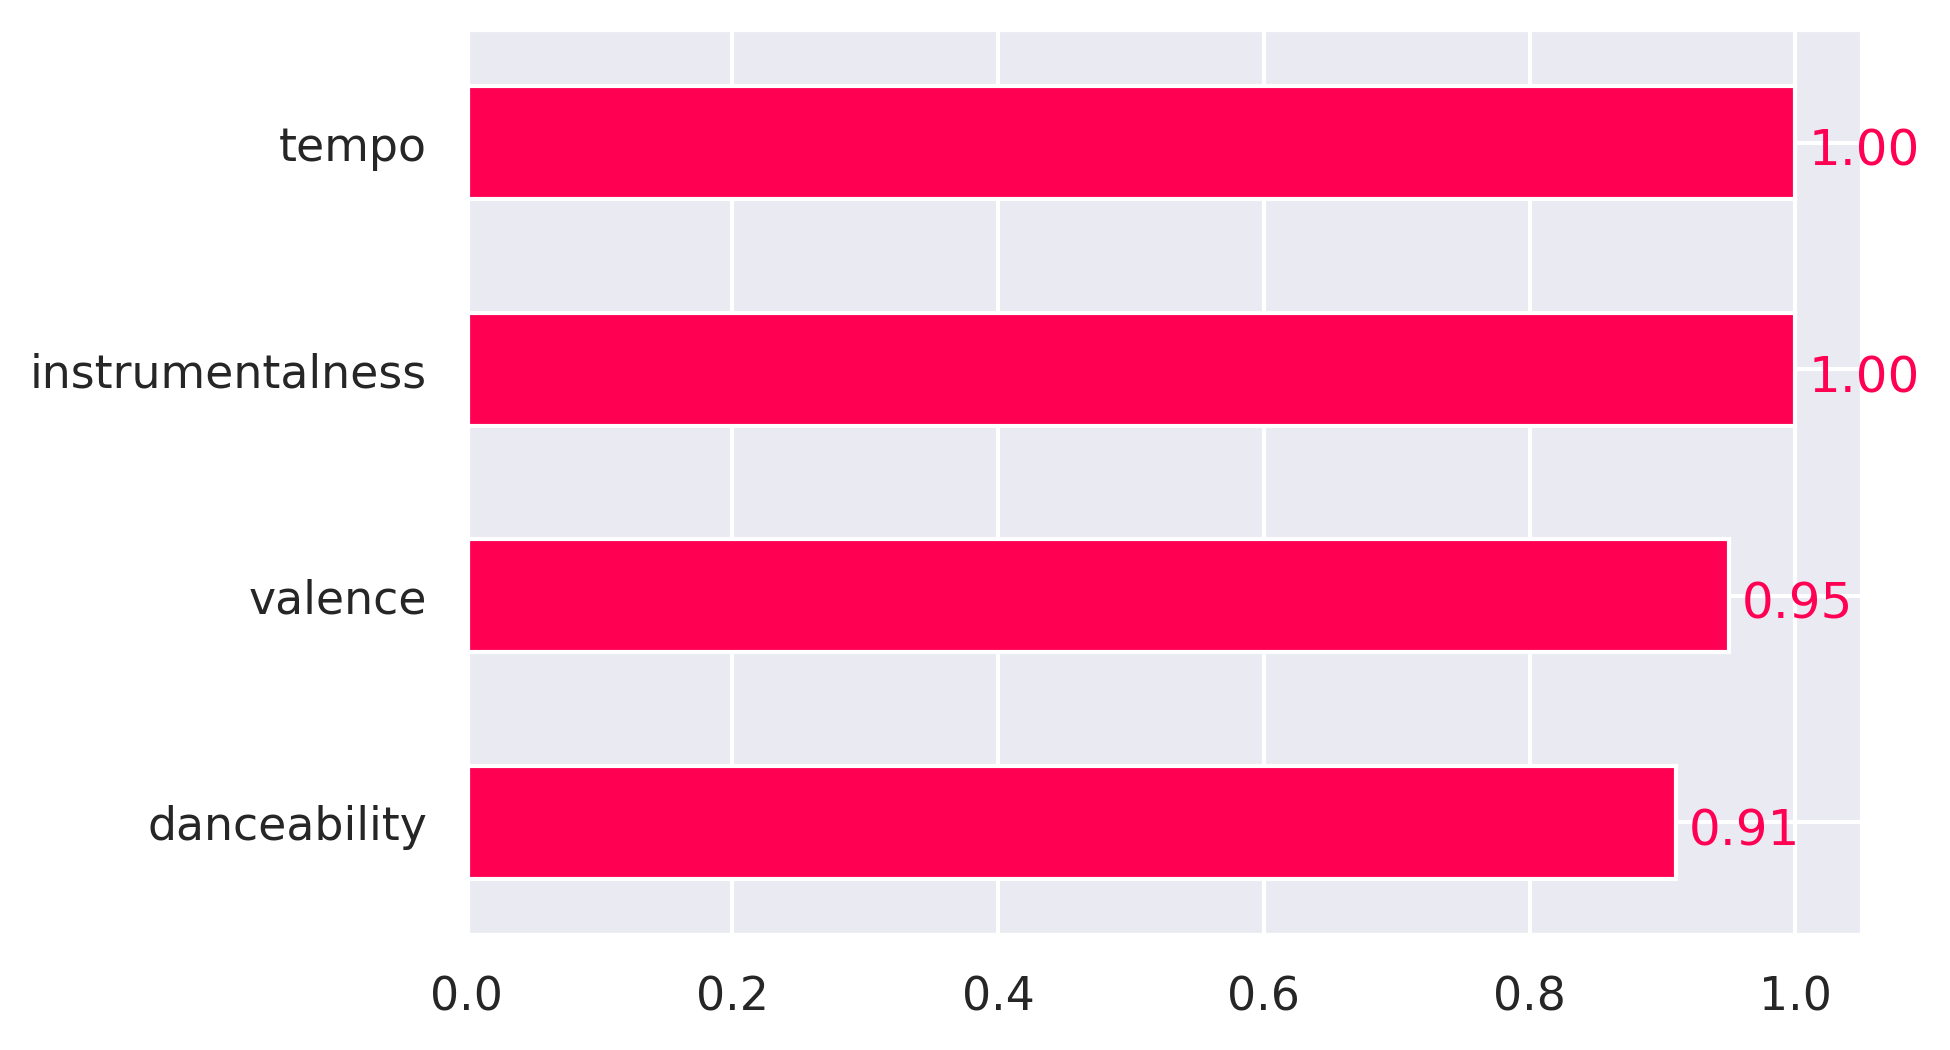

In [33]:
demo_02_local = pd.Series(local_feat_importance.local_importance[0])

fig, ax = plt.subplots()
(demo_02_local
 .loc[features_to_vary]
 .sort_values()
 .plot(kind='barh', ax=ax, color='#ff0053'))

# Add the values to the plot
for i, v in enumerate(demo_02_local.loc[features_to_vary].sort_values()):
    if v != 0.00:
        ax.text(v + 0.01, i - 0.1, f'{v:.2f}', color='#ff0053')
plt.show()

<center><span style="font-size:14px"><b>Figure 11. </b>Demo_02: DiCE Feature Importance Plot for Local Explanation</span></center>

**Insight:** The model attributes `duration_ms` and `valence` as negative contributors to the success of this song, hence it flopped.

In [34]:
cf_list = cfes2.cf_examples_list[0].final_cfs_df.drop('target', axis=1)

#### Counterfactual with smallest change with respect to Space Song

In [35]:
gs.predict_proba(cf_list.iloc[[1]])

array([[0.15746033, 0.84253967]])

In [36]:
cf_list.iloc[[1]]

danceability  energy  speechiness  instrumentalness  liveness  valence  \
0         0.509    0.79       0.0293               0.0     0.144    0.176   

   tempo  duration_ms  chorus_hit  
0  128.0     320467.0        42.9

In [37]:
build_pct_change_df(client, cf_list).mean(axis=1).nsmallest()#.to_frame().T

0     0.155462
12    0.179109
33    0.188463
27    0.197174
14    0.201737
dtype: float64

In [38]:
closest_hit_songs(df_db, cf_list, client, N=3)# [features_to_vary]

track                       artist  \
5633  The Edge Of Glory                    Lady Gaga   
3837    American Oxygen                      Rihanna   
639          All I Know  The Weeknd Featuring Future   

                                       uri  danceability  energy  key  \
5633  spotify:track:0JNdS1n0ifOP25XvhwAMgM         0.581   0.772    9   
3837  spotify:track:0bHA8LApeZHv7ZlhVUWg8X         0.391   0.745    2   
639   spotify:track:0NWqNXBJTpXbkI5rPWNy3p         0.469   0.417    8   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
5633    -6.544     1       0.0401      0.000343          0.019100     0.110   
3837    -6.296     1       0.0884      0.049700          0.000000     0.329   
639    -10.614     0       0.0704      0.418000          0.000189     0.102   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
5633    0.361  127.952       320587               4    63.05910         7   
3837    0.483   78.205       320161               4    38.37375        12   
639     0.175  120.012       321027               4    33.21344        13   

      target  
5633       1  
3837       1  
639        1

<a id='Demo_03'></a>
<h2 style="color:#3C89F3">E. Demo_03: Flop</h2> 

In this section, we explore a track with different versions, belonging to different outcomes, where the the team used `shap` to explain why the first version was predicted to be a flop by the model. Secondly, `shap` is again used to explain a second version of the same song predicted to be a hit and the second version's features as the counterfactual to the first version.

#### Flop version

danceability  energy  speechiness  instrumentalness  liveness  valence  \
0          0.66   0.604       0.0277                 0    0.0912    0.724   

     tempo  duration_ms  chorus_hit  
0  140.035       123827        34.0

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Prediction: [0]
Prediction Probabilities:


array([[0.75296868, 0.24703132]])

Closest hit songs:



track                          artist  \
2162                      Gucci Gang                        Lil Pump   
1077                Stuck In A Dream               Lil Mosey x Gunna   
5159  PPAP (Pen-Pineapple-Apple-Pen)                        PIKOTARO   
2389            Love Is An Open Door  Kristen Bell & Santino Fontana   
5787                It's Not Unusual                       Glee Cast   

                                       uri  danceability  energy  key  \
2162  spotify:track:43ZyHQITOjhciSUUNPVRHc         0.936   0.523    5   
1077  spotify:track:7iHHxY2NLlJRAmlAmC4ahQ         0.748   0.648   10   
5159  spotify:track:5qRj5I58zuHkVilcqVWN3P         0.892   0.527    1   
2389  spotify:track:3IPnBzGRMg6BfViFxxa0Gq         0.737   0.637    6   
5787  spotify:track:1kaVnEJOzERCdCKtQKGDUH         0.408   0.975    0   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
2162    -6.710     1       0.0597        0.2390             0.000    0.1170   
1077    -6.445     0       0.0816        0.4810             0.000    0.1260   
5159    -5.598     1       0.0631        0.0360             0.112    0.0612   
2389    -6.308     0       0.0735        0.2620             0.000    0.3190   
5787    -4.339     1       0.1370        0.0313             0.000    0.3530   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
2162    0.699  119.889       124056               4    77.54349         4   
1077    0.726  139.952       123560               4    26.68713         5   
5159    0.485  136.029       122933               4    23.80969         6   
2389    0.537  100.033       124733               4    54.18728         7   
5787    0.635  183.962       125267               4    71.73402         5   

      target  
2162       1  
1077       1  
5159       1  
2389       1  
5787       1

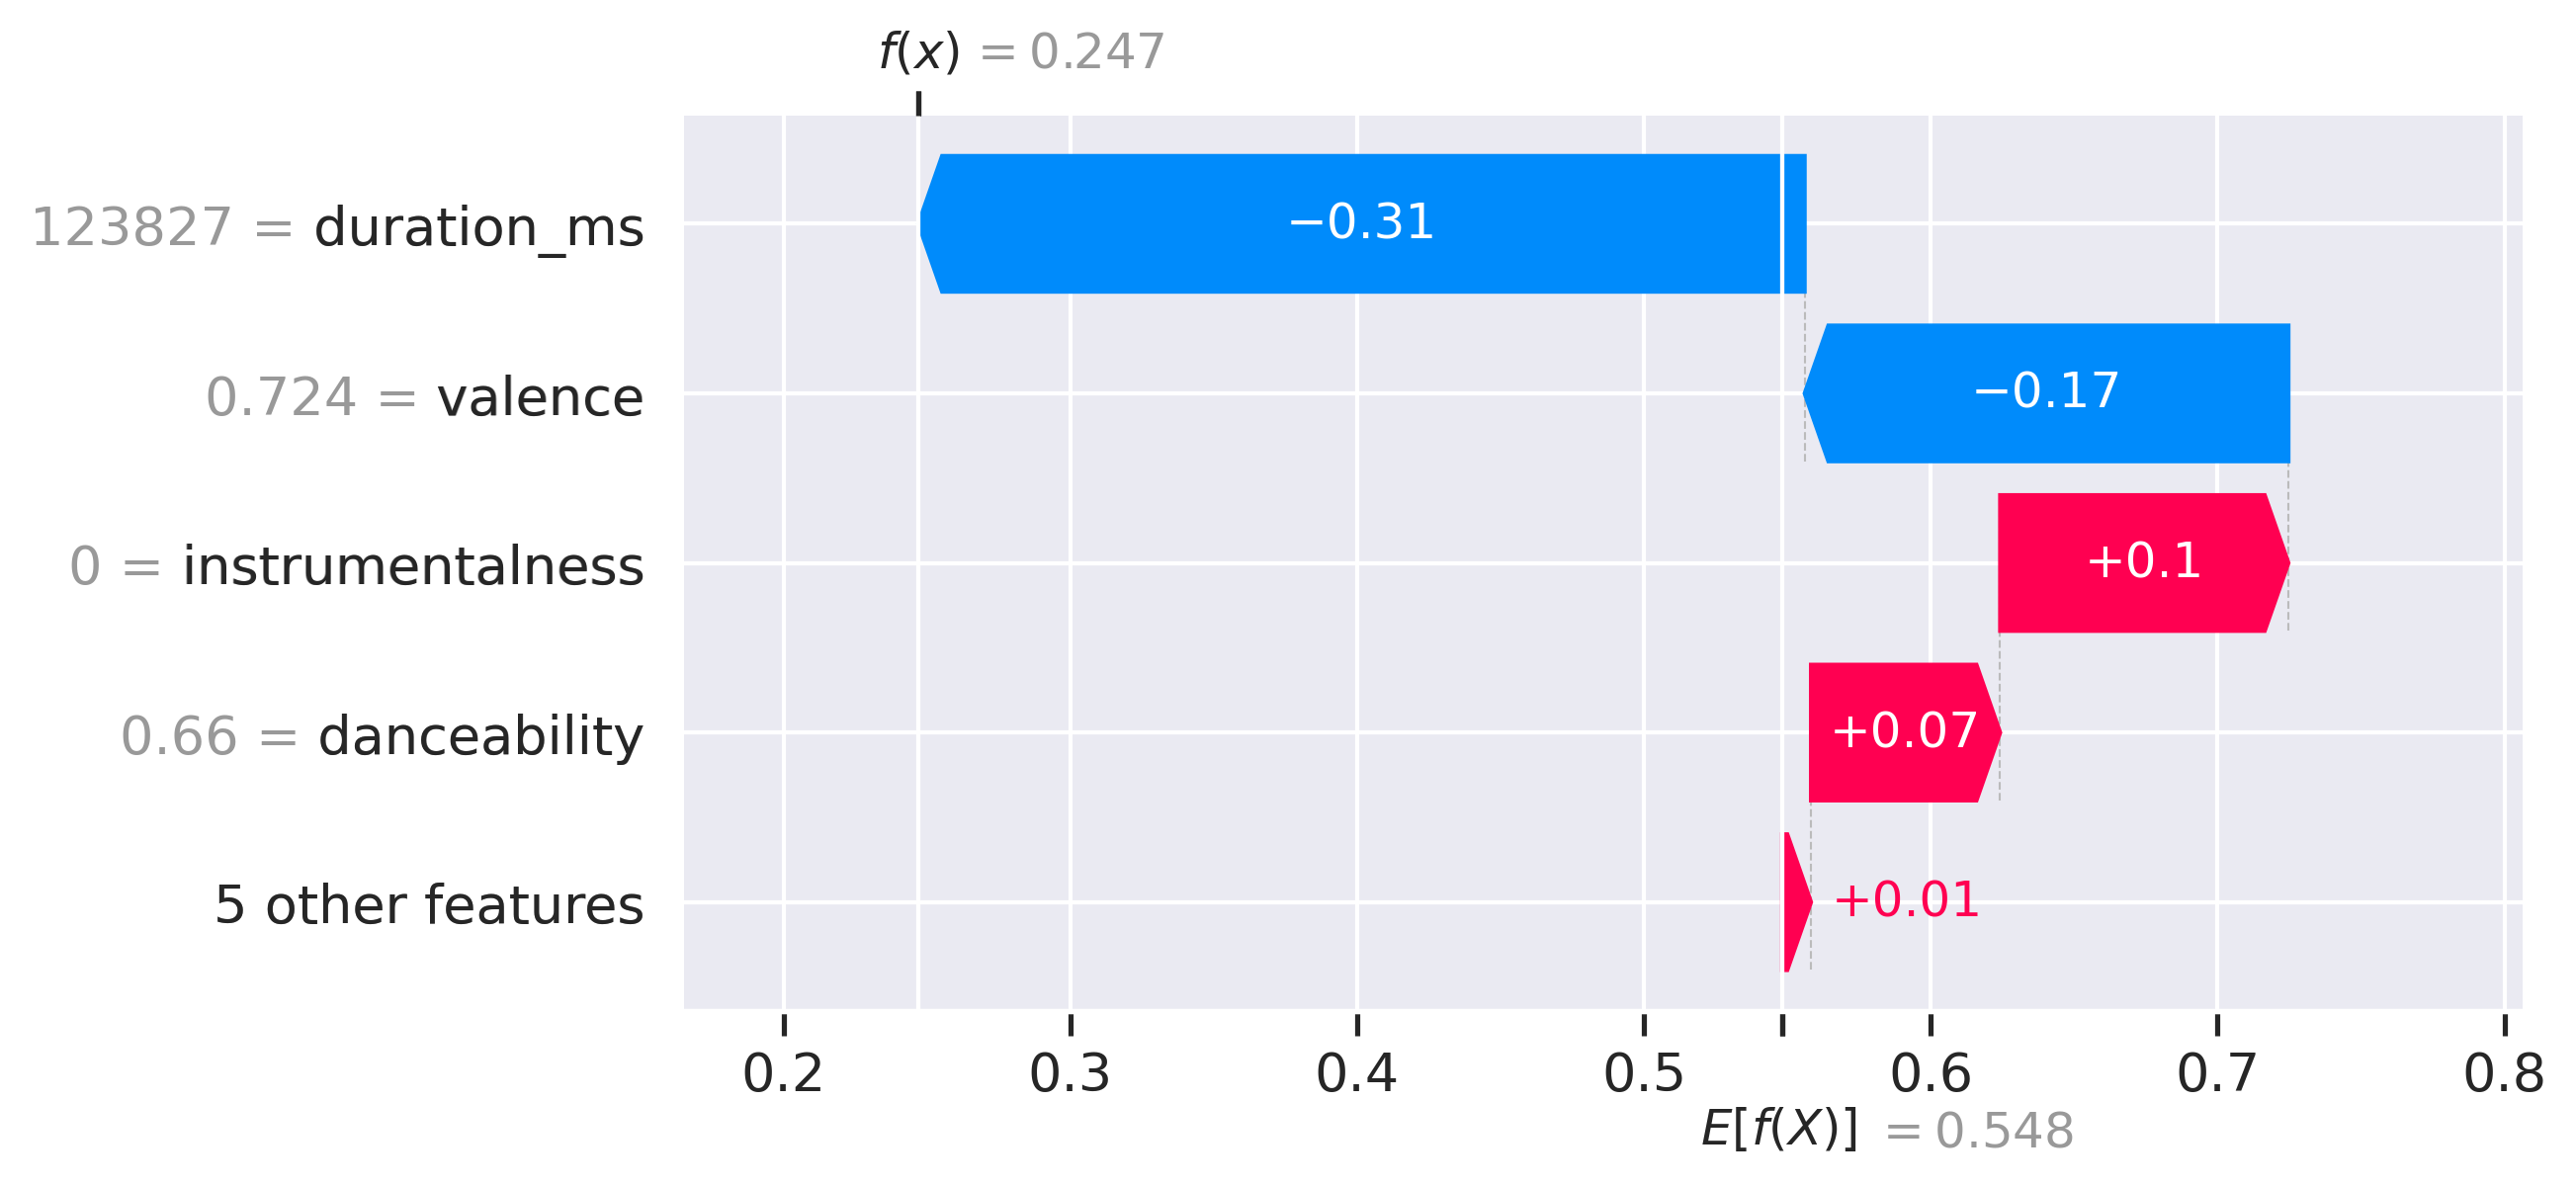

In [39]:
demo_result("What I've Been Looking For", "Ryan, Sharpay Evans, Disney", 34.0, df_db, 5)

<center><span style="font-size:14px"><b>Figure 12. </b>Demo_03: SHAP Waterfall Plot for Local Explanation (Flop Version)</span></center>

**Insight:** The model attributes `duration_ms` and `valence` as negative contributors to the success of this song, hence it flopped.

#### Hit version

danceability  energy  speechiness  instrumentalness  liveness  valence  \
0         0.584   0.265       0.0396                 0     0.159    0.226   

    tempo  duration_ms  chorus_hit  
0  110.03        79907        34.0

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

Prediction: [1]
Prediction Probabilities:


array([[0.34036395, 0.65963605]])

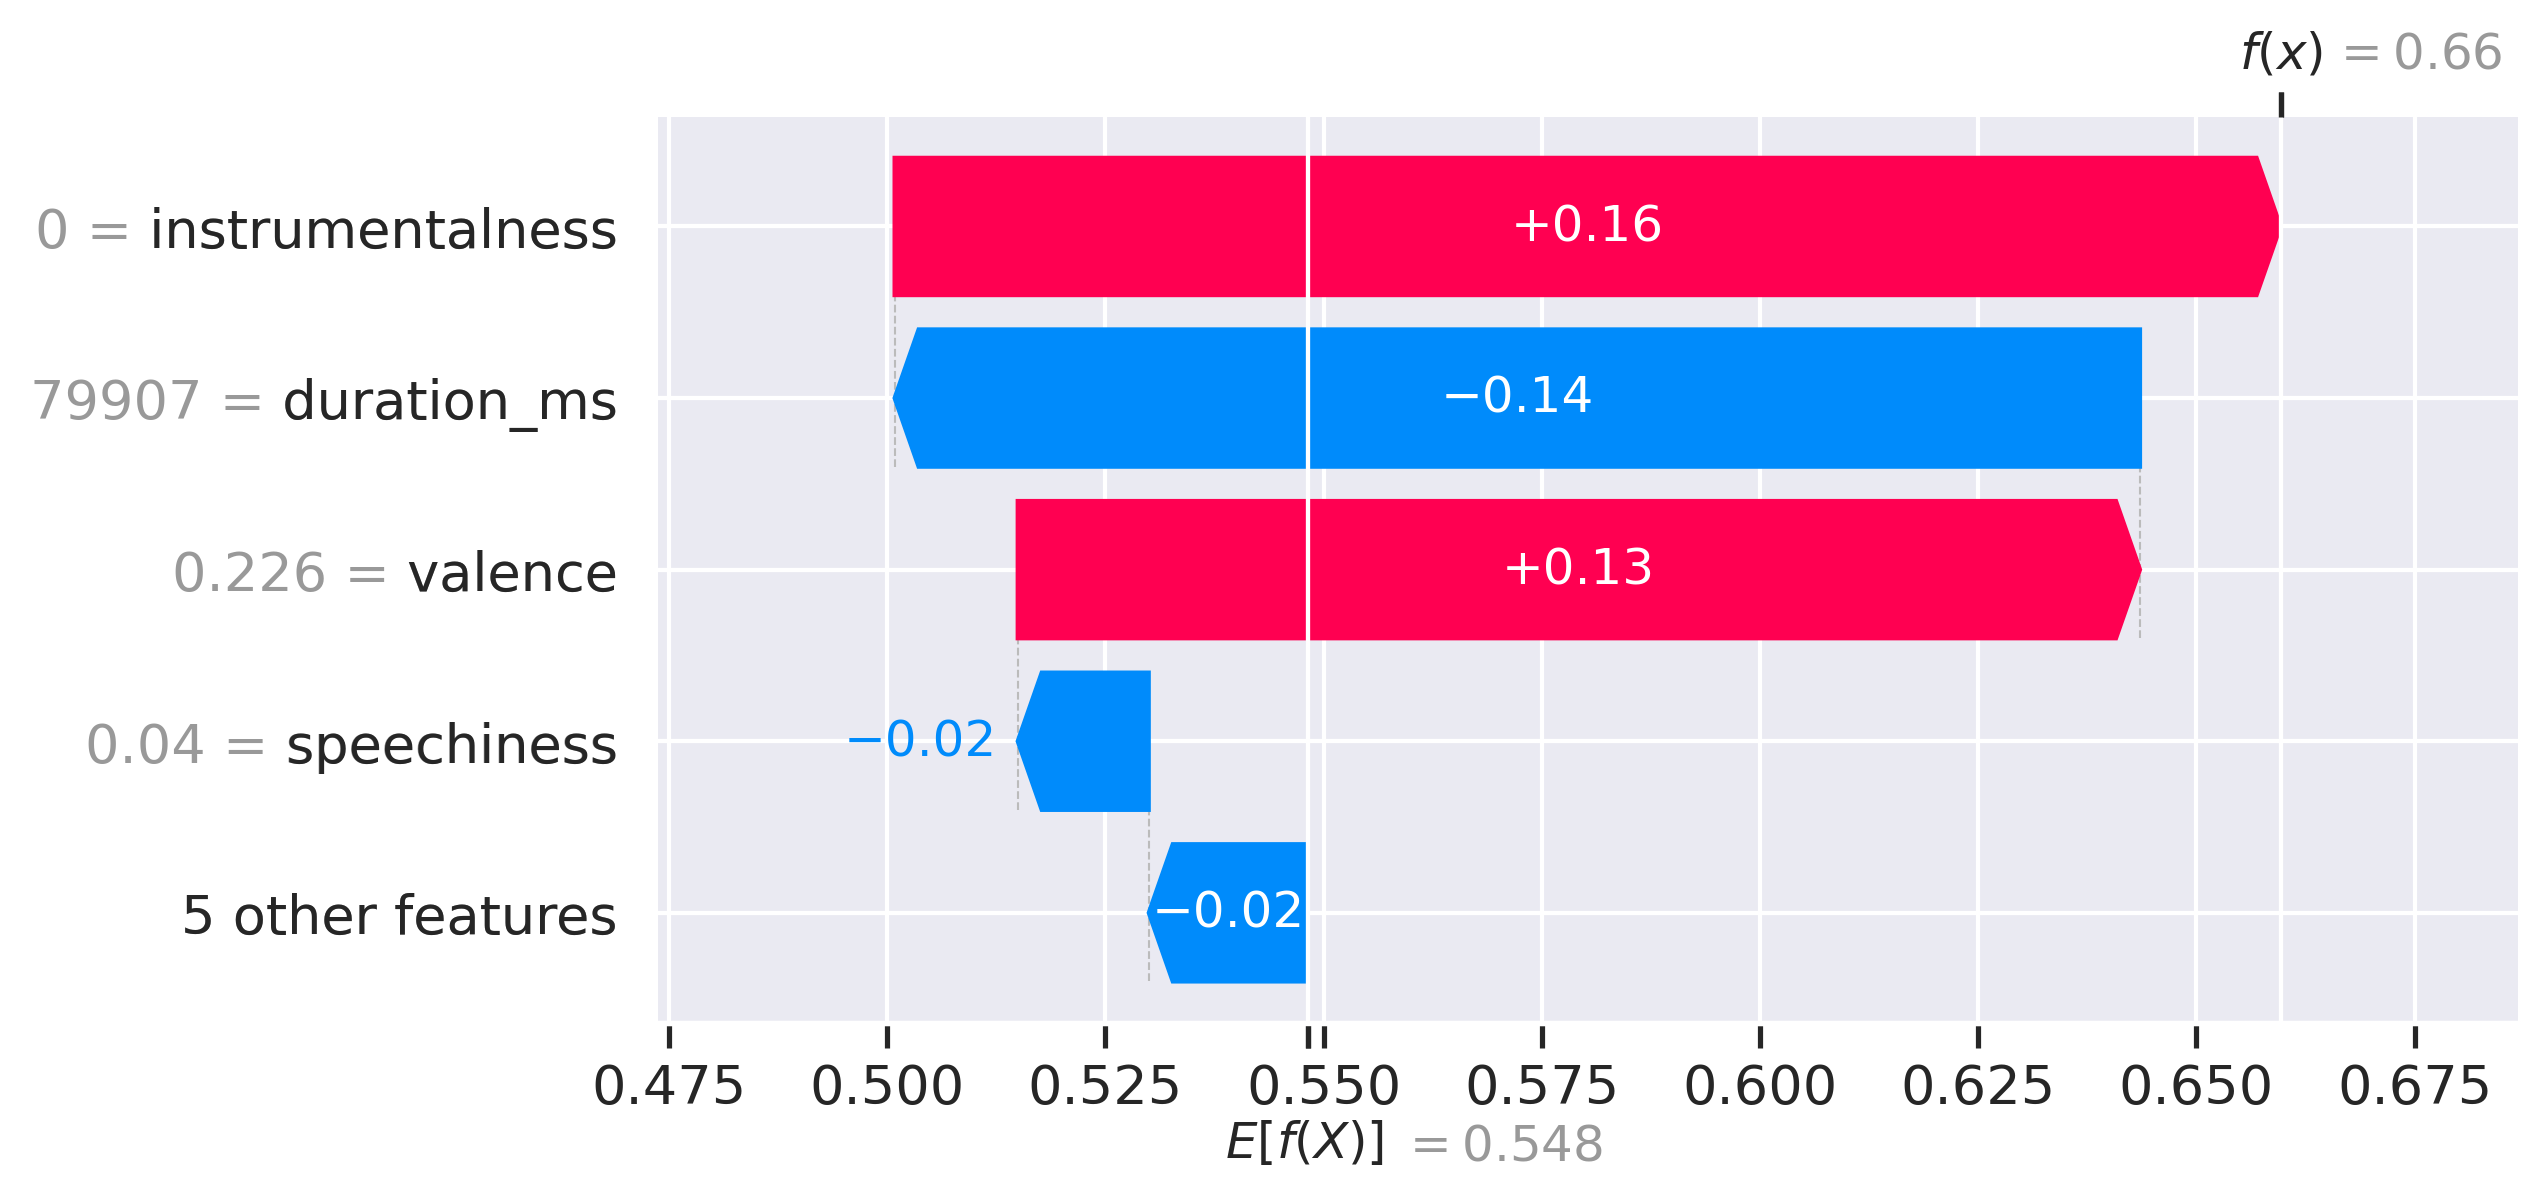

In [40]:
demo_result("What I've Been Looking For (Reprise)", "Troy, Gabriella Montez, Disney", 34.0, df_db, 5)

<center><span style="font-size:14px"><b>Figure 13. </b>Demo_03: SHAP Waterfall Plot for Local Explanation (Hit Version)</span></center>

**Insight:** For the 'reprise' version of the same song, which became a hit, the model attributes its success to having the right amount of `valence` and `instrumentalness`.

[Back to TOC](#TContents)

<a id='Conclusion'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">VIII. CONCLUSION</h1>

In conclusion, the following outlines the findings throughout this project:
- The project created a model that takes in various features of songs from Spotify API and predicts whether it is expected to be a hit or not. 
- Using `shap`, a post-hoc model-agnostic explainability method, the team discovered that `instrumentalness`, `danceability`, and `energy` contribute the most influence to the model's prediction. Moreover, using `dice_ml`,  the team was able to generate counterfactuals for a song predicted to be a flop and identify the minimal change that the owner of such a song can do to make the said song a hit. 
- The model can be used by artists, producers, and record labels alike to make informed decisions about their music and increase their chances of creating hits.

[Back to TOC](#TContents)

<a id='Recommendation1'></a>
<h1 style="color:#fcc5a8; background-color:#00436c; border: 1px; padding: 10px;">IX. RECOMMENDATION</h1>

<a id='Limitations'></a>
<h2 style="color:#3C89F3">Limitations</h2> 

It is important to acknowledge and understand the assumptions and limitations that may impact the performance of the model. The following list outlines some of the assumptions and limitations of the dataset used in this analysis: 
- The team only focused on doing an analysis on the 2010-2019 dataset and did not delve into analyzing the data from 1960s to 2000s.
- The team did not take into account the potential impact of the artists popularity, the quality of the lyrics, and the market power of the producer or agency and only focused on the **content of the song**.
- The team used a global definition of what is considered a 'Hit' or a 'Flop'.

<a id='Recommendation2'></a>
<h2 style="color:#3C89F3">Recommendation</h2> 

Each stakeholders below can benefit from using the model as follows: 
1. **Artists** 
- Improve the likelihood of the success of future songs by focusing on important features.
- Understand what changes they can make to improve their hit potential. 
2. **Music or Record Labels** 
- Sign artists who have high potential of success based on the Artist’s music features.
- Strategize and implement changes to an Artist’s song based on hit potential.
- Analyze a target singer's past songs that had the potential to become hits but failed to do so. So the Labels can explore other factors such as advertising to improve the chances of a song becoming a hit. 
3. **Streaming Platforms** 
- Prioritize songs to recommend or play songs to listeners based on the songs that are likely to be successful. 
4. **Advertisers** 
- Select songs with hit potential as part of the advertisements (e.g. Jollibee short advertising clips).

<a id='FutureWork'></a>
<h2 style="color:#3C89F3">Future Work</h2> 

For future works, the team recommends the following:

- Explore stricter and/or different definitions for target prediction such as platinum-award winning albums, Grammy/American Music Awards (AMAs) award winners, etc.
- Localize the data attribution to accommodate local, indie artists, and music industry.
- Consider clustering artists in the data and use it as a feature to include artist popularity to the model's predictions.
- Consider making a separate study taking into account the words used in the song and how it fits to the content of the song. 

[Back to TOC](#TContents)

<a id='References'></a>
# References

<a name='dataset'></a>[1] Ansari, F. (n.d.). The Spotify Hit Predictor Dataset (1960-2019) [Dataset]. Kaggle. Retrieved March 18, 2023, from https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset?select=dataset-of-10s.csv

<a name='CF'></a>[2] DeepFindr. (2021, March 17). Explainable AI explained! | #5 Counterfactual explanations and adversarial attacks [Video]. YouTube.
https://www.youtube.com/watch?v=UUZxRct8rIk


[Back to TOC](#TContents)